In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
from typing import Optional, Union, List, Tuple

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.collections import LineCollection
plt.style.use('seaborn-v0_8-darkgrid')


# Scientific computing and statistics
from scipy.stats import gaussian_kde
from tqdm import tqdm
import random

# Machine learning - sklearn
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine learning models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern

# Utilities
import warnings
from warnings import filterwarnings
filterwarnings('ignore')
warnings.filterwarnings('ignore')
import joblib
import torch 

# Utilities

In [2]:
def preprocess_yfinance(df: pd.DataFrame) -> pd.DataFrame:
    df.rename(columns={'Price': 'Date'}, inplace=True)
    df.drop(columns=['Open', 'High', 'Low'], inplace=True)
    df = df[2:]
    df['Date'] = pd.to_datetime(df['Date'])
    df['Volume'] = df['Volume'].astype(int)/1000000
    return df

def predict_X_horizons(sample,model,horizons):
    preds = []
    for i in range(1,horizons):
        sample['forecast_horizon'] = i
        y_pred = model.predict(sample)
        print(f'Horizon {i}: {y_pred[0]}')
        preds.append(y_pred[0])
    return preds

def augment_by_task(df, target_col, horizons, tasks):
    """
    Augment dataset by introducing multiple tasks and horizons.

    Args:
        df (pd.DataFrame): Original dataset.
        target_col (str): Name of the target column.
        horizons (List[int]): Forecast horizons to include.
        tasks (List[str]): Task types to augment (e.g., 'regression', 'trend', 'percent_change').

    Returns:
        pd.DataFrame: Augmented dataset with task_type and Target.
    """
    augmented_data = []

    # Ensure the target column is numeric
    df[target_col] = pd.to_numeric(df[target_col], errors='coerce')

    for horizon in horizons:
        for task in tasks:
            task_df = df.copy()
            if task == "regression":
                task_df["Target"] = task_df[target_col].shift(-horizon)
                task_df["task_type"] = "regression"
            elif task == "trend":
                task_df["Target"] = (task_df[target_col].shift(-horizon) > task_df[target_col]).astype(int)
                task_df["task_type"] = "trend"
            elif task == "percent_change":
                task_df["Target"] = ((task_df[target_col].shift(-horizon) - task_df[target_col]) / task_df[target_col]) * 100
                task_df["task_type"] = "percent_change"
            elif task == "reverse":
                task_df["Target"] = task_df[target_col].shift(horizon)  # Predicting past values
                task_df["task_type"] = "reverse"
            else:
                raise ValueError(f"Unknown task type: {task}")

            task_df["forecast_horizon"] = horizon
            task_df = task_df.dropna()
            augmented_data.append(task_df)

    return pd.concat(augmented_data, ignore_index=True)

def analyze_time_windows(df, col_name, window_length, num_samples, random_seed=None):
    """
    Analyze time series data by sampling random windows and computing statistics
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Get the series data
    series = df[col_name]
    
    # Calculate the maximum starting index
    max_start = len(series) - window_length
    
    # Generate random starting indices
    start_indices = np.random.randint(0, max_start, num_samples)
    
    # Initialize lists to store statistics
    means = []
    stds = []
    ranges = []
    skews = []
    windows = []
    window_indices = []
    
    # Calculate statistics for each window
    for start_idx in start_indices:
        window = series.iloc[start_idx:start_idx + window_length]
        windows.append(window)
        window_indices.append((start_idx, start_idx + window_length))
        
        means.append(window.mean())
        stds.append(window.std())
        ranges.append(window.max() - window.min())
        skews.append(window.skew())
    
    # Create visualizations
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Mean distribution
    ax1 = fig.add_subplot(2, 2, 1)
    sns.histplot(means, kde=True, color="#3498db", ax=ax1)
    ax1.axvline(np.mean(means), color="red", linestyle='--', 
                label=f'Mean: {np.mean(means):.2f}')
    ax1.set_title(f'Distribution of Means for {col_name}', fontsize=16, fontweight='bold')
    ax1.set_xlabel('Mean Value', fontsize=14)
    ax1.legend()
    
    # 2. Standard deviation distribution
    ax2 = fig.add_subplot(2, 2, 2)
    sns.histplot(stds, kde=True, color="#2ecc71", ax=ax2)
    ax2.axvline(np.mean(stds), color="red", linestyle='--', 
                label=f'Mean: {np.mean(stds):.2f}')
    ax2.set_title(f'Distribution of Standard Deviations', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Standard Deviation', fontsize=14)
    ax2.legend()
    
    # 3. Joint distribution
    ax3 = fig.add_subplot(2, 2, 3)
    sns.kdeplot(x=means, y=stds, fill=True, cmap="viridis", levels=10, ax=ax3)
    sns.scatterplot(x=means, y=stds, color='white', edgecolor='black', s=50, ax=ax3)
    corr = np.corrcoef(means, stds)[0, 1]
    ax3.text(0.05, 0.95, f"Correlation: {corr:.2f}", transform=ax3.transAxes, 
             fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax3.set_title('Joint Distribution of Mean and Std Dev', fontsize=16, fontweight='bold')
    ax3.set_ylabel('Standard Deviation', fontsize=14)
    ax3.set_xlabel('Mean Value', fontsize=14)
    
    # 4. Sample time series windows
    num_to_plot = min(5, num_samples)
    ax4 = fig.add_subplot(2, 2, 4)
    for i in range(num_to_plot):
        plt.plot(windows[i].values, label=f'Window {i+1}')
    ax4.set_title('Sample Time Windows', fontsize=16, fontweight='bold')
    ax4.set_xlabel('Time Steps', fontsize=14)
    ax4.set_ylabel('Value', fontsize=14)
    ax4.legend()
    
    plt.tight_layout()
    
    # Return results dictionary
    return {
        'means': means,
        'stds': stds,
        'ranges': ranges,
        'skews': skews,
        'windows': windows,
        'window_indices': window_indices,
        'figure': fig
    }



def preprocess_FRED(df: pd.DataFrame) -> pd.DataFrame:
    df.rename(columns={'observation_date': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Date'].dt.year 
    df['Month'] = df['Date'].dt.month
    df = df.groupby(['Year', 'Month']).first().reset_index()
    df['Date'] = df['Date'].apply(lambda x: x.replace(day=1))
    df.drop(columns=['Year', 'Month'], inplace=True)
    return df

def create_lagged_features(df: pd.DataFrame, lags: int) -> pd.DataFrame:
    features = [col for col in df.columns if col != 'Target']
    for feature in features:
        for lag in range(1, lags+1):
            df[f'{feature}_lag_{lag}'] = df[feature].shift(lag)
    return df


def create_multi_horizon_dataset(
    df: pd.DataFrame,
    target_col: str,
    forecast_horizons: List[int]
) -> pd.DataFrame:
    augmented_data = []

    for horizon in forecast_horizons:
        shifted_df = df.copy()
        # Shift the target column to create the forecast horizon target
        shifted_df["Target"] = shifted_df[target_col].shift(-horizon)
        shifted_df["Target_Pct_Change"] = (shifted_df["Target"] - shifted_df[target_col]) / shifted_df[target_col]
        # Add the forecast horizon as a feature
        shifted_df["forecast_horizon"] = horizon
        # Drop rows with NaN (due to shifting)
        shifted_df = shifted_df.dropna()
        # Keep only necessary columns
        augmented_data.append(shifted_df)

    # Concatenate all augmented data
    final_dataset = pd.concat(augmented_data, ignore_index=True)

    return final_dataset

# Function to apply operations on each group (forecast horizon)
def diff_target_per_group(df):
    for g in df['forecast_horizon'].unique():
        mask = df['forecast_horizon'] == g
        df.loc[mask, 'Target'] = df.loc[mask, 'Target'].diff(periods=g)
    return df


def time_series_cv_evaluation(X, y, models_dict, n_splits=6, test_size=3, gap=0):
    """
    Perform time series cross-validation with multiple models
    
    Parameters:
    -----------
    X : pd.DataFrame
        Features
    y : pd.Series
        Target variable
    models_dict : dict
        Dictionary of model_name: model_instance
    n_splits : int
        Number of splits for cross-validation
    test_size : int
        Number of periods in test set for each fold
    gap : int
        Gap between train and test sets
    
    Returns:
    --------
    results_df : pd.DataFrame
        Comprehensive results table
    """
    
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)
    
    # Store all results
    all_results = []
    fold_predictions = {}
    
    # Initialize prediction storage for each model
    for model_name in models_dict.keys():
        fold_predictions[model_name] = {'actual': [], 'predicted': [], 'dates': []}
    
    print(f"Starting Time Series Cross-Validation with {n_splits} splits...")
    print(f"Test size: {test_size} periods, Gap: {gap} periods\n")
    
    # Perform cross-validation
    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"Train period: {X.index[train_idx[0]]} to {X.index[train_idx[-1]]}")
        print(f"Test period: {X.index[test_idx[0]]} to {X.index[test_idx[-1]]}")
        
        # Split data
        X_train_fold = X.iloc[train_idx]
        X_test_fold = X.iloc[test_idx]
        y_train_fold = y.iloc[train_idx]
        y_test_fold = y.iloc[test_idx]
        
        # Test each model
        for model_name, model in models_dict.items():
            try:
                # Clone and fit model
                model_clone = type(model)(**model.get_params())
                model_clone.fit(X_train_fold, y_train_fold)
                
                # Make predictions
                y_pred = model_clone.predict(X_test_fold)
                
                # Calculate metrics
                mse = mean_squared_error(y_test_fold, y_pred)
                mae = mean_absolute_error(y_test_fold, y_pred)
                r2 = r2_score(y_test_fold, y_pred)
                rmse = np.sqrt(mse)
                
                # Calculate additional metrics
                mape = np.mean(np.abs((y_test_fold - y_pred) / y_test_fold)) * 100
                bias = np.mean(y_pred - y_test_fold)
                
                # Store results
                result = {
                    'fold': fold + 1,
                    'model': model_name,
                    'train_start': X.index[train_idx[0]],
                    'train_end': X.index[train_idx[-1]],
                    'test_start': X.index[test_idx[0]],
                    'test_end': X.index[test_idx[-1]],
                    'train_size': len(train_idx),
                    'test_size': len(test_idx),
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'r2': r2,
                    'mape': mape,
                    'bias': bias
                }
                all_results.append(result)
                
                # Store predictions for plotting
                fold_predictions[model_name]['actual'].extend(y_test_fold.values)
                fold_predictions[model_name]['predicted'].extend(y_pred)
                fold_predictions[model_name]['dates'].extend(X_test_fold.index)
                
                print(f"  {model_name}: R² = {r2:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}")
                
            except Exception as e:
                print(f"  Error with {model_name}: {str(e)}")
        
        print("-" * 50)
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)
    
    return results_df, fold_predictions

def create_results_summary(results_df):
    """Create summary statistics table"""
    
    summary_stats = results_df.groupby('model').agg({
        'r2': ['mean', 'std', 'min', 'max'],
        'rmse': ['mean', 'std', 'min', 'max'],
        'mae': ['mean', 'std', 'min', 'max'],
        'mape': ['mean', 'std', 'min', 'max'],
        'bias': ['mean', 'std', 'min', 'max']
    }).round(4)
    
    # Flatten column names
    summary_stats.columns = [f'{metric}_{stat}' for metric, stat in summary_stats.columns]
    
    # Add rank based on mean R²
    summary_stats['r2_rank'] = summary_stats['r2_mean'].rank(ascending=False)
    
    return summary_stats.sort_values('r2_rank')

def plot_cv_results(results_df, fold_predictions):
    """Create comprehensive visualization of CV results"""
    
    # Set style
    plt.style.use('seaborn-v0_8-whitegrid')
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Performance metrics by fold
    ax1 = plt.subplot(2, 3, 1)
    metrics_plot = results_df.pivot(index='fold', columns='model', values='r2')
    sns.heatmap(metrics_plot, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax1)
    ax1.set_title('R² Score by Fold and Model')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Fold')
    
    # 2. RMSE distribution
    ax2 = plt.subplot(2, 3, 2)
    sns.boxplot(data=results_df, x='model', y='rmse', ax=ax2)
    ax2.set_title('RMSE Distribution Across Folds')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. R² distribution
    ax3 = plt.subplot(2, 3, 3)
    sns.boxplot(data=results_df, x='model', y='r2', ax=ax3)
    ax3.set_title('R² Distribution Across Folds')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Bias vs Variance plot
    ax4 = plt.subplot(2, 3, 4)
    bias_variance = results_df.groupby('model').agg({'bias': 'mean', 'rmse': 'std'}).reset_index()
    sns.scatterplot(data=bias_variance, x='bias', y='rmse', s=100, ax=ax4)
    for i, txt in enumerate(bias_variance['model']):
        ax4.annotate(txt, (bias_variance['bias'].iloc[i], bias_variance['rmse'].iloc[i]), 
                    xytext=(5, 5), textcoords='offset points')
    ax4.set_title('Bias vs Variance Trade-off')
    ax4.set_xlabel('Mean Bias')
    ax4.set_ylabel('RMSE Standard Deviation')
    
    # 5. Performance over time
    ax5 = plt.subplot(2, 3, 5)
    for model_name in fold_predictions.keys():
        model_results = results_df[results_df['model'] == model_name]
        ax5.plot(model_results['fold'], model_results['r2'], marker='o', label=model_name)
    ax5.set_title('R² Performance Over Folds')
    ax5.set_xlabel('Fold')
    ax5.set_ylabel('R² Score')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Actual vs Predicted for best model
    ax6 = plt.subplot(2, 3, 6)
    best_model = results_df.groupby('model')['r2'].mean().idxmax()
    best_model_data = fold_predictions[best_model]
    
    ax6.scatter(best_model_data['actual'], best_model_data['predicted'], alpha=0.6)
    min_val = min(min(best_model_data['actual']), min(best_model_data['predicted']))
    max_val = max(max(best_model_data['actual']), max(best_model_data['predicted']))
    ax6.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
    ax6.set_title(f'Actual vs Predicted - {best_model}')
    ax6.set_xlabel('Actual')
    ax6.set_ylabel('Predicted')
    
    plt.tight_layout()
    return fig


def smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE).
    """
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def plot_predictions_in_grid(y_test, X_test, model, unique_horizons, n_cols=3):
    """
    Plot predictions vs actuals for each forecast horizon in a grid layout.

    Args:
        y_test (pd.Series): True values of the target variable.
        X_test (pd.DataFrame): Test set features, including 'forecast_horizon'.
        model: Trained model for predictions.
        unique_horizons (List[int]): List of unique forecast horizons.
        n_cols (int): Number of plots per row in the grid.
    """
    n_horizons = len(unique_horizons)
    n_rows = (n_horizons + n_cols - 1) // n_cols  # Calculate rows needed for the grid

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
    axes = axes.flatten()  # Flatten in case of more subplots than needed

    for i, uq in enumerate(unique_horizons):
        # Filter data for the current horizon
        y_sample = y_test[y_test.index.isin(X_test[X_test['forecast_horizon'] == uq].index)]
        y_pred = pd.Series(model.predict(X_test[X_test['forecast_horizon'] == uq]), index=y_sample.index)

        # Calculate R² and SMAPE
        r2 = r2_score(y_sample, y_pred)
        smape_val = smape(y_sample.values, y_pred.values)

        # Plot actual vs predicted
        ax = axes[i]
        sns.lineplot(x=y_sample.index, y=y_sample.values, label='Actual', ax=ax)
        sns.lineplot(x=y_pred.index, y=y_pred.values, label='Predicted', ax=ax)

        # Annotate values
        for x, y in zip(y_sample.index, y_sample.values):
            ax.text(x, y, f"{y:.2f}", fontsize=8, color='blue')
        for x, y in zip(y_pred.index, y_pred.values):
            ax.text(x, y, f"{y:.2f}", fontsize=8, color='orange')

        # Title with R² and SMAPE
        ax.set_title(f'Horizon {uq:.2f} | R²: {r2:.2f} | SMAPE: {smape_val:.2f}%')

        ax.set_xlabel('Index')
        ax.set_ylabel('Value')
        ax.legend()

    # Hide unused subplots if n_cols * n_rows > n_horizons
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.show()
    
def plot_predictions_timeline(fold_predictions, results_df):
    """Plot prediction timeline for all models"""
    
    fig, axes = plt.subplots(len(fold_predictions), 1, figsize=(20, 4*len(fold_predictions)))
    if len(fold_predictions) == 1:
        axes = [axes]
    
    for i, (model_name, data) in enumerate(fold_predictions.items()):
        ax = axes[i]
        
        # Convert to series for easier plotting
        dates = pd.to_datetime(data['dates'])
        actual_series = pd.Series(data['actual'], index=dates)
        pred_series = pd.Series(data['predicted'], index=dates)
        
        # Plot
        ax.plot(dates, actual_series, 'b-', label='Actual', linewidth=2)
        ax.plot(dates, pred_series, 'r--', label='Predicted', linewidth=2, alpha=0.8)
        
        # Add fold boundaries
        fold_boundaries = results_df[results_df['model'] == model_name]['test_start'].unique()
        for boundary in fold_boundaries:
            ax.axvline(boundary, color='gray', linestyle=':', alpha=0.5)
        
        # Calculate overall R²
        overall_r2 = r2_score(data['actual'], data['predicted'])
        
        ax.set_title(f'{model_name} - Predictions Over Time (Overall R² = {overall_r2:.3f})')
        ax.set_xlabel('Date')
        ax.set_ylabel('Target Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig
def prepare_data(df: pd.DataFrame, test_size: int):
    """
    Prepares the data for training and testing by scaling and splitting.

    Args:
        df (pd.DataFrame): The input dataframe.
        test_size (int): The number of samples to leave for testing.

    Returns:
        X_train, X_test, y_train, y_test, scaler: The split and scaled datasets and the scaler used.
    """
    df_copy = df.copy()
    # Calculate the 12-month percentage change and shift it
    # Using shift(-12) means the target will be the next 12-month return
    df_copy['Target'] = df_copy['Close_spx'].pct_change(-12) * 100
    df_copy.dropna(inplace=True)
    
    scaler = MinMaxScaler(feature_range=(0, 100))
    cols_to_scale = [col for col in df_copy.columns if 'Target' not in col]
    df_copy[cols_to_scale] = pd.DataFrame(scaler.fit_transform(df_copy[cols_to_scale]), columns=cols_to_scale, index=df_copy.index)

    X = df_copy.drop(columns='Target')
    X.drop(columns=['Close_spx'], inplace=True)
    y = df_copy['Target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train, X_test, y_train, y_test, scaler,df_copy



def custom_train_test_split(df, test_size_per_horizon: int):
    """
    Splits the dataset into training and testing sets, ensuring that each forecast horizon
    has a fixed number of samples in the test set.

    Args:
        df (pd.DataFrame): The dataset with 'forecast_horizon' and 'Target' columns.
        test_size_per_horizon (int): Number of samples to leave in the test set for each horizon.

    Returns:
        X_train, X_test, y_train, y_test: Split and scaled datasets.
    """
    # Initialize train and test sets
    train_data = []
    test_data = []

    # Group by forecast_horizon and split
    for horizon, group in df.groupby("forecast_horizon"):
        test_samples = group.tail(test_size_per_horizon)
        train_samples = group.drop(test_samples.index)

        test_data.append(test_samples)
        train_data.append(train_samples)

    # Concatenate train and test data
    train_data = pd.concat(train_data)
    test_data = pd.concat(test_data)

    # Split into features (X) and target (y)
    X_train = train_data.drop(columns="Target")
    y_train = train_data["Target"]

    X_test = test_data.drop(columns="Target")
    y_test = test_data["Target"]

    # Scale the features
    scaler = MinMaxScaler()

    cols_to_scale = [col for col in X_train.columns if 'forecast_horizon' not in col]

    X_train[cols_to_scale] = pd.DataFrame(scaler.fit_transform(X_train[cols_to_scale]), columns=cols_to_scale, index=X_train.index)
    X_test[cols_to_scale] = pd.DataFrame(scaler.transform(X_test[cols_to_scale]), columns=cols_to_scale,index=X_test.index)

    # Ensure y is numeric
    y_train = y_train.astype(float)
    y_test = y_test.astype(float)

    return X_train, X_test, y_train, y_test

def monte_carlo_simulation(start_states, end_states, mus, sigmas, timesteps, iterations, range_percent):
    """
    Monte Carlo simulation to calculate probability of reaching end states within a range.
    
    Parameters:
    -----------
    start_states : array-like
        Initial values for each variable
    end_states : array-like
        Target values for each variable
    mus : array-like
        Mean of the difference per timestep for each variable
    sigmas : array-like
        Standard deviation of the difference per timestep for each variable
    timesteps : int
        Number of timesteps to simulate
    iterations : int
        Number of Monte Carlo simulations to run
    range_percent : float
        Percentage range around end states (e.g., 5 for ±5%)
        
    Returns:
    --------
    float : Probability of reaching the target range
    dict : Additional information including successful paths
    """
    # Convert inputs to numpy arrays
    start_states = np.array(start_states)
    end_states = np.array(end_states)
    mus = np.array(mus)
    sigmas = np.array(sigmas)
    
    n_vars = len(start_states)
    
    # Calculate acceptable ranges for end states

    lower_bounds = end_states - abs(200) * (range_percent/100) 
    upper_bounds = end_states + abs(200) * (range_percent/100) 
    
    # Store all paths and successful paths for visualization
    all_paths = np.zeros((iterations, timesteps + 1, n_vars))
    successful_paths = []
    
    # Count successful simulations
    success_count = 0
    
    # Run simulations
    for i in tqdm(range(iterations), desc="Running simulations", unit="iteration"):
        # Start from initial state
        current_states = start_states.copy()
        path = np.zeros((timesteps + 1, n_vars))
        path[0] = current_states
        
        # Simulate for each timestep
        for t in range(timesteps):
            # Generate random changes based on mus and sigmas
            random_changes = np.random.normal(loc=mus, scale=sigmas)
            current_states += random_changes
            path[t+1] = current_states
        
        # Store the complete path
        all_paths[i] = path
        
        # Check if final state is within range of target end state
        if np.all((current_states >= lower_bounds) & (current_states <= upper_bounds)):
            success_count += 1
            successful_paths.append(path)
        if success_count == 1:
            print(f"Successful path: {path[-1,:]}")
    # Calculate probability
    probability = (success_count / iterations) * 100
    
    result = {
        'probability': probability,
        'success_count': success_count,
        'all_paths': all_paths,
        'successful_paths': successful_paths if successful_paths else None
    }
    
    return probability, result

def visualize_flow_network(results,
                            start_states,
                              end_states,
                                var_names=None,
                                range_percent=5,
                                  figsize=(18, 12)):
    """
    Creates a professional flow visualization of Monte Carlo paths
    
    Parameters:
    -----------
    results : dict
        Output from monte_carlo_simulation function
    start_states : array-like
        Initial values for each variable
    end_states : array-like
        Target values for each variable
    var_names : list or None
        Names of the variables (for legend)
    figsize : tuple
        Figure size
    """
    all_paths = results['all_paths']
    successful_paths = results['successful_paths']
    n_vars = all_paths.shape[2]
    timesteps = all_paths.shape[1] - 1
    
    if var_names is None:
        var_names = [f"Variable {i+1}" for i in range(n_vars)]
    
    # Create custom colormaps
    flow_cmap = LinearSegmentedColormap.from_list('flow_gradient', 
                                                ['#f5f5f5', '#2171b5'], N=256)
    success_cmap = LinearSegmentedColormap.from_list('success_gradient', 
                                                   ['#4daf4a', '#ffff33'], N=256)
    
    # Set up the plot with a dark background for professional look
    plt.style.use('dark_background')
    fig = plt.figure(figsize=figsize, facecolor='#111111')
    
    # Create a grid of subplots
    rows = int(np.ceil(n_vars / 2))
    cols = min(2, n_vars)
    
    # Main plots for each variable
    axes = []
    for i in tqdm(range(n_vars), desc="Plotting variables", unit="variable"):
        ax = fig.add_subplot(rows, cols, i+1)
        axes.append(ax)
        
        # Plot time steps
        time_steps = np.arange(all_paths.shape[1])
        
        # Plot density of all paths
        all_var_paths = all_paths[:,:,i].T
        
        # Compute the point density for flow effect
        for t in range(1, len(time_steps)-1):
            points = all_var_paths[t]
            if len(points) > 10:  # Need enough points for KDE
                density = gaussian_kde(points)(points)
                # Normalize density
                density = (density - density.min()) / (density.max() - density.min() + 1e-10)
                
                # Scatter with density coloring
                ax.scatter(np.ones_like(points) * t, points, 
                          c=density, cmap=flow_cmap, alpha=0.3, s=3)
        
        # Plot all paths with low opacity to create a flow effect
        sample_paths = min(300, all_paths.shape[0])  # Limit for performance
        for j in range(sample_paths):
            ax.plot(time_steps, all_paths[j,:,i], color='#a6cee3', alpha=0.05, lw=0.9)
        
        # Plot successful paths if they exist
        if successful_paths:
            for path in successful_paths:
                ax.plot(time_steps, path[:,i], color='#33a02c', alpha=0.25, lw=1.2)
        
        # Plot start and end points
        ax.scatter(0, start_states[i], color='white', s=100, zorder=5, label='Start')
        ax.scatter([timesteps, timesteps], 
              [end_states[i] - abs(end_states[i]) * range_percent / 100, end_states[i] + abs(end_states[i]) * range_percent / 100], 
              color='#ff7f00', s=100, zorder=5, alpha=0.7, marker='|', label='Target Range')
        ax.scatter(timesteps, end_states[i], color='#ff7f00', s=100, zorder=5, marker='o', label='Target')
        
        # Add a horizontal line at the end state
        ax.axhline(end_states[i], color='#ff7f00', linestyle='--', alpha=0.3)
        
        # Styling
        ax.set_title(f"{var_names[i]} Flow", color='white', fontsize=14)
        ax.set_xlabel("Time Step", color='white', fontsize=12)
        ax.set_ylabel("Value", color='white', fontsize=12)
        ax.tick_params(colors='white')
        for spine in ax.spines.values():
            spine.set_color('#555555')
        
        # Add grid for better readability
        ax.grid(True, alpha=0.2)
        
    # Add a title showing the success probability
    plt.suptitle(f"Flow Visualization of Monte Carlo Paths\nSuccess Probability: {results['probability']:.2f}%", 
                 color='white', fontsize=18, y=0.98)
    
    # Add explanatory text at the bottom
    success_text = f"{results['success_count']} out of {all_paths.shape[0]} paths reached target range"
    fig.text(0.5, 0.01, success_text, ha='center', color='#cccccc', fontsize=12)
    
    # Add legends to the first subplot only to avoid redundancy
    if axes:
        handles, labels = axes[0].get_legend_handles_labels()
        if successful_paths:
            # Add a custom legend entry for successful paths
            success_line = Line2D([0], [0], color='#33a02c', lw=2)
            handles.append(success_line)
            labels.append('Successful Paths')
        
        # Add the legend outside the subplots area
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), 
                  ncol=len(handles), frameon=False, fontsize=12)
    
    plt.tight_layout(rect=[0, 0.07, 1, 0.95])
    return fig

def max_drawdown(df,col,period):
    series = df[col].pct_change(periods=period)
    series = series.dropna()
    min_d = series.min()
    return min_d,series.idxmin()

class TimeSeriesEnsembleRegressor(BaseEstimator, RegressorMixin):
    """Ensemble regressor for time series with uncertainty estimates.

    This estimator builds an ensemble of linear regressors. For each estimator,
    it samples a consecutive time window from the input dataframe to train on.
    At prediction time, predictions from each estimator are aggregated to provide
    the mean prediction, as well as uncertainty bounds based on the desired coverage.

    Attributes:
        time_window (int): Number of consecutive samples for each estimator's training.
        num_estimators (int): Number of estimators in the ensemble.
        coverage (float): Desired prediction coverage (e.g., 0.95 for a 95% prediction interval).
        target_column (str): Name of the target column in the dataframe.
        estimators (List[LinearRegression]): List of trained LinearRegression models.
        random_state (Optional[int]): Random state for reproducibility.
    """

    def __init__(self,
                 time_window: int = 10,
                 num_estimators: int = 50,
                 coverage: float = 0.95,
                 target_column: str = 'target',
                 random_state: Optional[int] = None) -> None:
        self.time_window = time_window
        self.num_estimators = num_estimators
        self.coverage = coverage
        self.target_column = target_column
        self.random_state = random_state
        self.estimators: List[LinearRegression] = []

    def fit(self, df: pd.DataFrame) -> 'TimeSeriesEnsembleRegressor':
        """Fit the ensemble estimator using time window samples from the dataframe.

        Args:
            df (pd.DataFrame): Input dataframe containing features and the target column.

        Returns:
            TimeSeriesEnsembleRegressor: The fitted estimator.
        """
        np.random.seed(self.random_state)
        n_samples = df.shape[0]
        if n_samples < self.time_window:
            raise ValueError(
                'The dataframe has fewer rows than the specified time_window.'
            )

        # Features are all columns except the target
        feature_columns = [col for col in df.columns if col != self.target_column]
        self.estimators = []

        for _ in tqdm(range(self.num_estimators)):
            # Randomly sample a starting index for a consecutive time window
            start_idx = np.random.randint(0, n_samples - self.time_window + 1)
            end_idx = start_idx + self.time_window
            subset = df.iloc[start_idx:end_idx]
            X_train = subset[feature_columns].values
            y_train = subset[self.target_column].values
            # lr = random.choice([Ridge(alpha = random.uniform(0, 10)),
            #                     Lasso(alpha= random.uniform(0, 10)),
            #                     LinearRegression(),
            #                     DecisionTreeRegressor(max_depth=random.randint(2, 5))])
            lr = random.choice([DecisionTreeRegressor(max_depth=random.randint(2, 8))])
            lr.fit(X_train, y_train)
            self.estimators.append(lr)
        # print Distribution of estimators(Count per type)
        estimator_types = [type(est).__name__ for est in self.estimators]
        estimator_counts = pd.Series(estimator_types).value_counts()
        print("Distribution of estimators (Count per type):")
        print(estimator_counts)
        return self

    def predict(self, X: Union[pd.DataFrame, np.ndarray]
                ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Predict using the ensemble estimator.

        For each input sample, predictions from all estimators are aggregated to compute
        the mean prediction and uncertainty bounds.

        Args:
            X (Union[pd.DataFrame, np.ndarray]): Input features for prediction.
                If a pandas DataFrame is provided, it should contain the same feature columns
                (excluding the target) as used in training.

        Returns:
            Tuple[np.ndarray, np.ndarray, np.ndarray]:
                A tuple containing:
                - Mean predictions.
                - Lower bound predictions.
                - Upper bound predictions.
        """
        if isinstance(X, pd.DataFrame):
            # Ensure only the feature columns are used if DataFrame is provided.
            feature_columns = [col for col in X.columns if col != self.target_column]
            X_values = X[feature_columns].values
        else:
            X_values = X

        # Collect predictions from each estimator
        predictions = np.array([estimator.predict(X_values) for estimator in self.estimators])
        mean_pred = predictions.mean(axis=0)

        # Compute quantiles for uncertainty bounds
        lower_quantile = (1 - self.coverage) / 2
        upper_quantile = 1 - lower_quantile
        lb = np.quantile(predictions, lower_quantile, axis=0)
        ub = np.quantile(predictions, upper_quantile, axis=0)
        std = predictions.std(axis=0)

        return mean_pred, lb, ub, std

# Initial Data Preparation


In [ ]:
spx = pd.read_csv(r"reproducability/data/^SPX_1mo_1980-01-01_to_2023-01-01.csv")
ndx = pd.read_csv(r"reproducability/data/^NDX_1mo_1980-01-01_to_2023-01-01.csv")
vix = pd.read_csv(r"reproducability/data/^VIX_1mo_1994-01-01_to_2023-01-01.csv")
long_term_yields = pd.read_csv(r'reproducability/data/LongTermBondYields2.csv')
lower_yields = pd.read_csv(r"reproducability/data/Lower US High Yield Index Effective Yield2.csv")

spx = preprocess_yfinance(spx)
ndx = preprocess_yfinance(ndx)
vix = preprocess_yfinance(vix)
lower_yields = preprocess_FRED(lower_yields)
long_term_yields = preprocess_FRED(long_term_yields)

# Merging all dfs into one
df = pd.merge(spx, ndx, on='Date', how='inner',suffixes=('_spx', '_ndx'))
df = pd.merge(df, vix, on='Date', how='inner',suffixes=('_spx', '_vix'))
df = pd.merge(df, long_term_yields, on='Date', how='inner')
df = pd.merge(df, lower_yields, on='Date', how='inner')
df.set_index('Date', inplace=True)
df.rename(columns = {'Close':"Close_vix"},inplace=True)
df.drop(columns=['Volume'], inplace=True)
# make sure all cols are numeric
df = df.apply(pd.to_numeric)


# Min - Max consecutive 12 months returns analysis

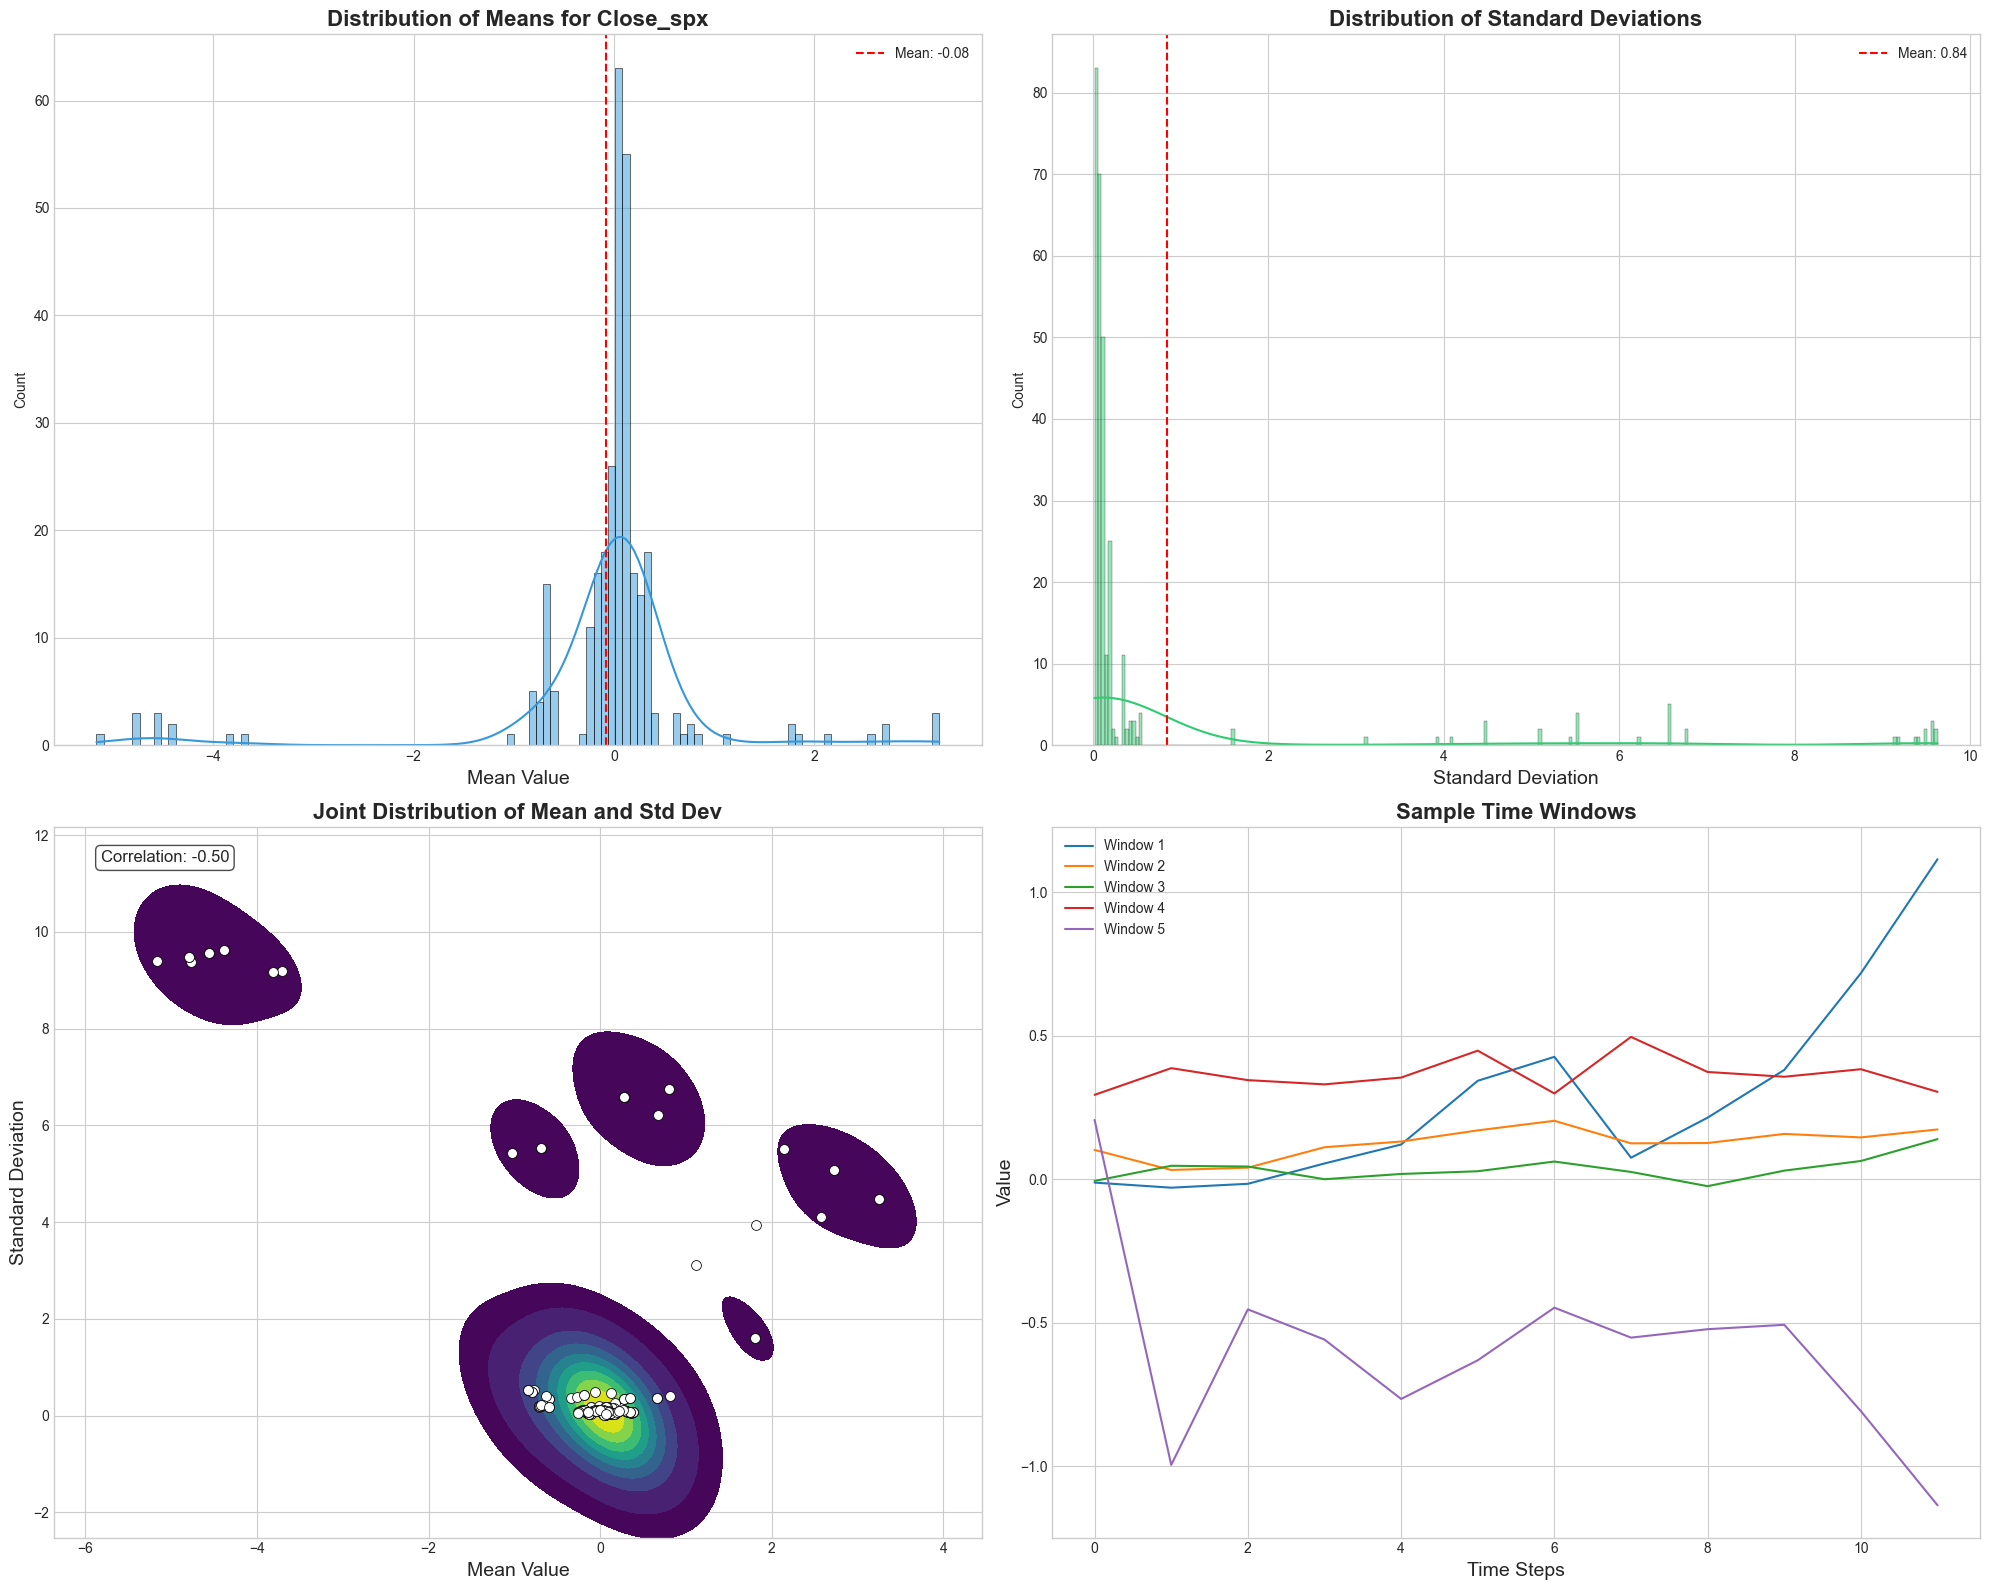

In [4]:
scaled_df = df.copy()
scaler = MinMaxScaler((-100, 100))
scaled_df = scaler.fit_transform(scaled_df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns, index=df.index)
res = analyze_time_windows(
    scaled_df.pct_change(-12).dropna(),
    col_name='Close_spx',
    window_length=12,
    num_samples=300,
    random_seed=40
)


In [37]:

# Assuming you have a DataFrame `df` with columns including 'feature1', 'feature2', ..., and a 'target' column
ensemble_reg = TimeSeriesEnsembleRegressor(
    time_window=60,
    num_estimators=10000,
    coverage=0.80,
    target_column='Target',
    random_state=42
)

cols_except_target = [col for col in df.columns if col != 'Target']
df_scaled = df.copy()
scaler = MinMaxScaler((-100, 100))
df_scaled = pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)
df_scaled['Target'] = df_scaled['Close_spx'].pct_change(-12)*100
df_scaled.dropna(inplace=True)

# split train and test
train_size = int(len(df_scaled) * 0.96)
train_df = df_scaled[:train_size]
test_df = df_scaled[train_size:]
# Fit the ensemble with your DataFrame
ensemble_reg.fit(train_df)

# For prediction, pass a DataFrame or numpy array of features (without target)
mean_preds, lower_bounds, upper_bounds,std = ensemble_reg.predict(test_df.drop(columns=['Target']))
# R2 of test
r2 = r2_score(test_df['Target'], mean_preds)
print(f"R2 of test: {r2:.4f}")

100%|██████████| 10000/10000 [00:03<00:00, 2856.11it/s]


Distribution of estimators (Count per type):
DecisionTreeRegressor    10000
Name: count, dtype: int64
R2 of test: -0.7329


Plotting variables: 100%|██████████| 6/6 [00:01<00:00,  3.71variable/s]


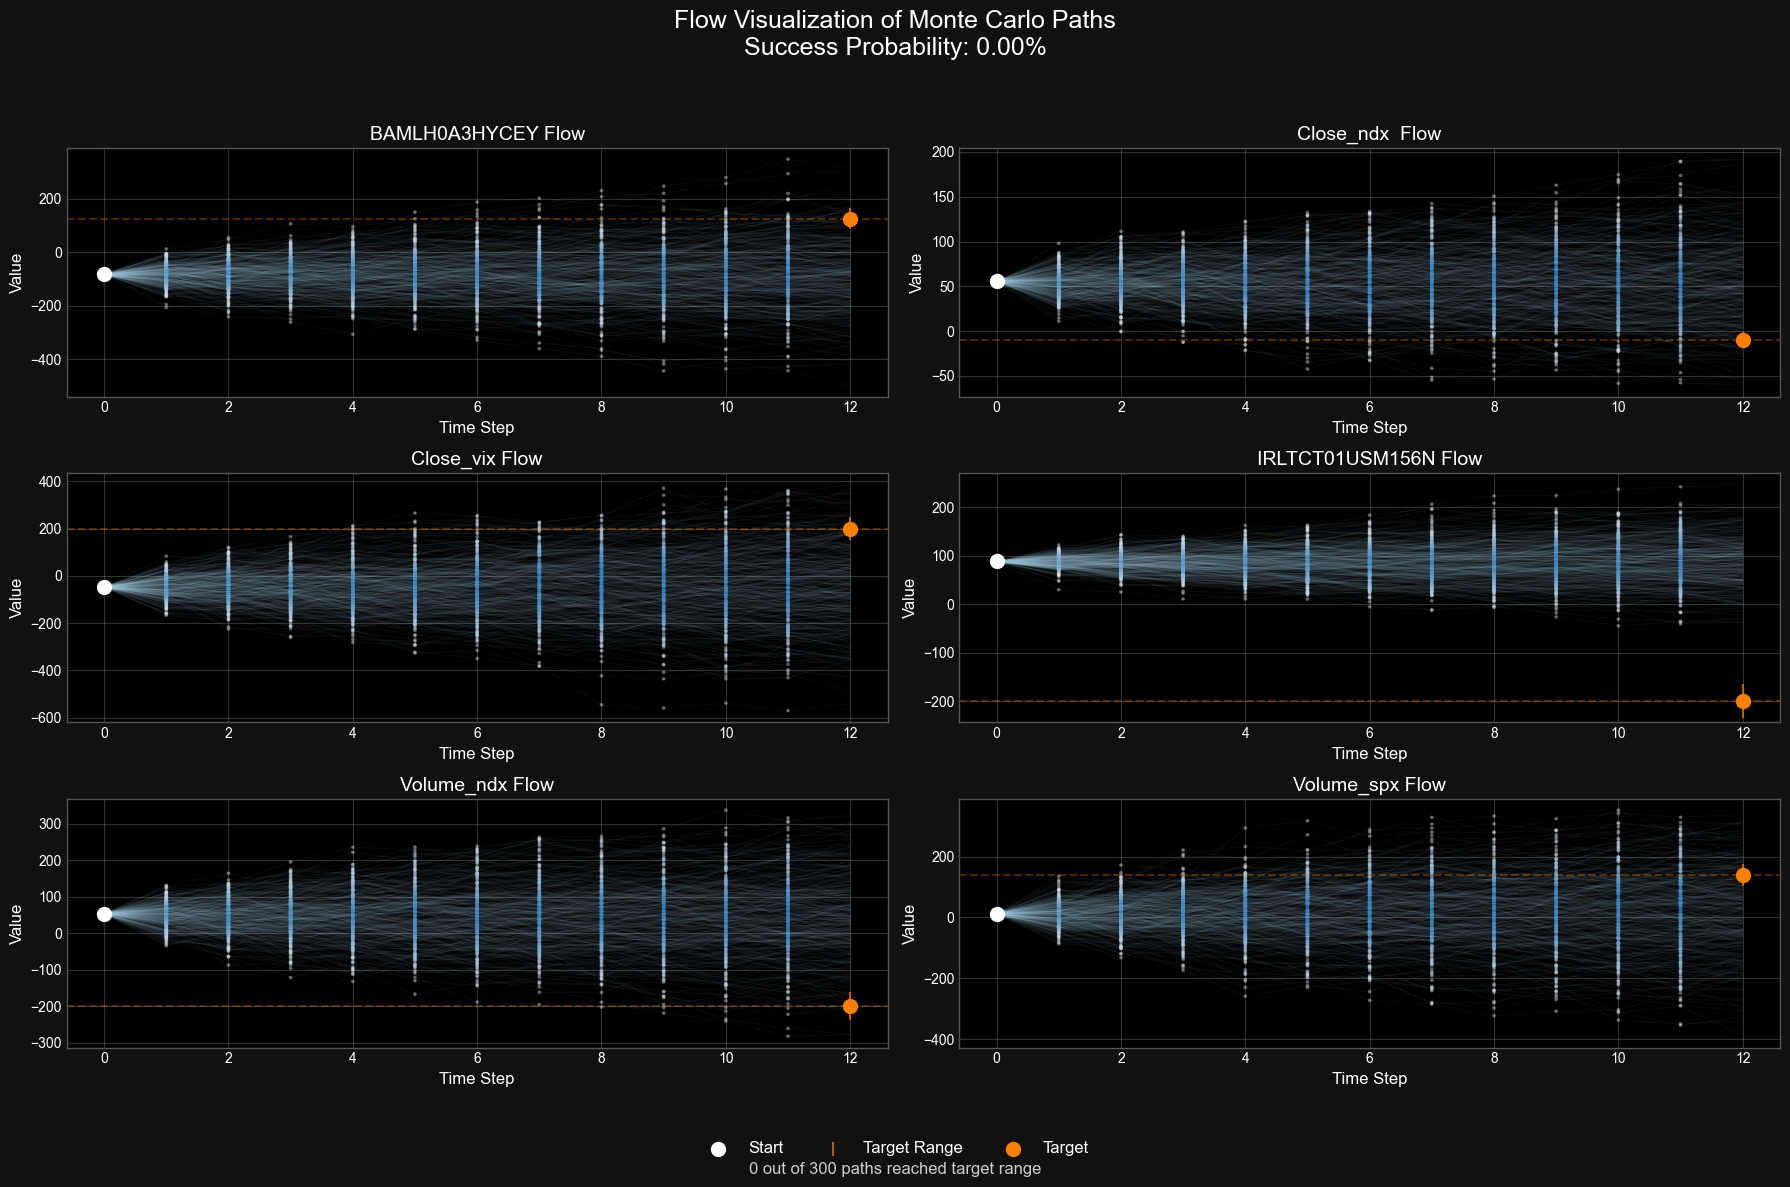

In [5]:


# Run the simulation
probas, results = monte_carlo_simulation(
    start_states=[-82.352, 55.683, -47.439, 88.41, 53.10,12.669],
    end_states=[126,-10, 200, -200, -200, 140],
    mus=list(np.array([0.34, 1.1, 2.34, 0.13, 1.86, 1.95])*0),
    sigmas=list(np.array([35, 14, 45.32, 13.17, 32, 40])),
    timesteps=12,
    iterations=300,
    range_percent=50
)

if results['successful_paths'] is not None:
    print(f"Probability of reaching target range: {results['probability']:.2f}%")
# # Visualize the results with custom variable names
var_names = ["BAMLH0A3HYCEY", "Close_ndx ", "Close_vix", "IRLTCT01USM156N", "Volume_ndx","Volume_spx"]
fig = visualize_flow_network(results, 
                          start_states=[-82.352, 55.683, -47.439, 88.41, 53.10, 12.669],
                          end_states=[126,  -10, 200, -200, -200, 140],
                          var_names=var_names,
                          range_percent=10)
plt.show()


In [4]:
df_1 = df.loc[:'2002-01-01']
df_2 = df.loc[:'2009-01-01']
df_3 = df.loc[:'2023-01-01']

In [9]:
max_d = max_drawdown(df_3,'Close_spx',12)
print(max_d)

(-0.44756241467724345, Timestamp('2009-02-01 00:00:00'))


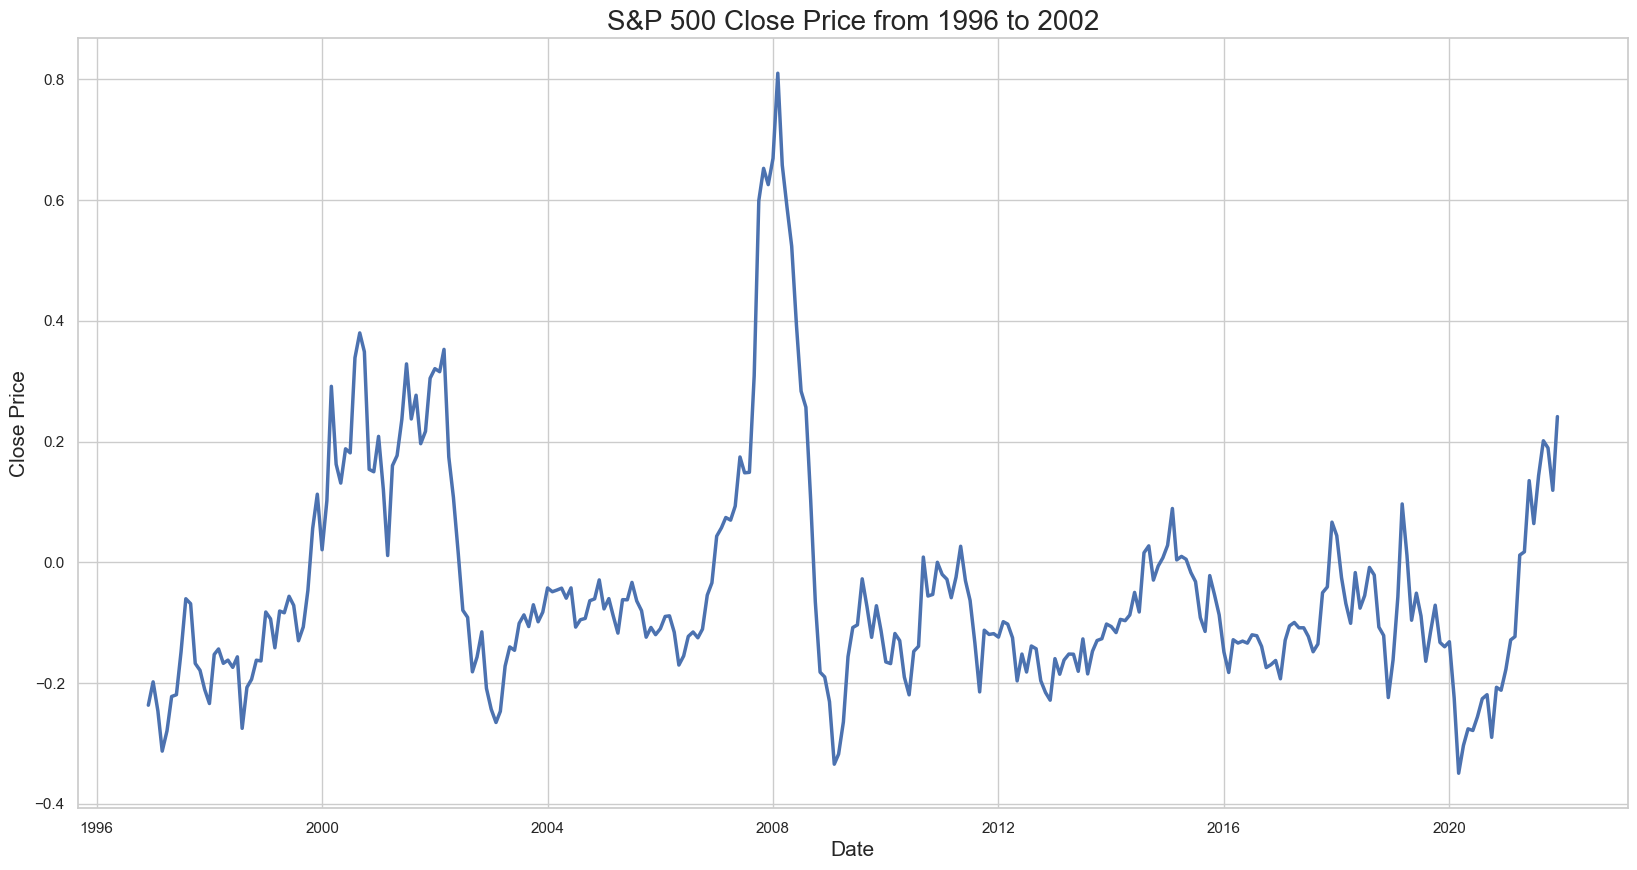

In [10]:
# Plot df profesionnaliy Close_spx column from 1996 to 2004, seaborn style

sns.set_theme(style="whitegrid")
plt.figure(figsize=(20, 10))
sns.lineplot(data=df['Close_spx'].pct_change(-12), linewidth=2.5)
plt.title('S&P 500 Close Price from 1996 to 2002', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price', fontsize=15)
plt.show()

In [ ]:
df = create_lagged_features(df, 12)
# df = create_multi_horizon_dataset(df, 'Close_spx', [1, 2, 3, 4,5,6,7,8,9,10,11,12])
# cols_to_remove  = [col for col in df.columns if 'Close_spx' in col]
# df.drop(columns = cols_to_remove,inplace=True)

In [ ]:

# Example Usage
df.drop(columns=['Target'],inplace=True)
df.rename(columns = {'Target_Pct_Change':'Target'},inplace=True)
test_size_per_horizon = 12  # Leave 5 samples per horizon in the test set
X_train, X_test, y_train, y_test = custom_train_test_split(df_1, test_size_per_horizon)

# Inspect the splits
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


In [5]:
df_1 = df.loc[:'2002-01-01']
df_2 = df.loc[:'2009-01-01']
df_3 = df.loc[:'2023-01-01']

In [20]:

# Example usage
test_size = 12  # Number of samples to leave for testing
X_train, X_test, y_train, y_test, scaler,df_copy = prepare_data(df_1, test_size)

# Inspect the splits
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


Train set size: (38, 6) (38,)
Test set size: (12, 6) (12,)


In [21]:
df_copy.drop(columns = ['Close_spx'],inplace=True)
df_copy['id'] = 1
df_copy.reset_index(inplace=True)

In [22]:
df_copy, df_copy_test = train_test_split(df_copy, test_size=12, shuffle=False)

In [23]:
import pandas as pd  # requires: pip install 'pandas[pyarrow]'
from chronos import Chronos2Pipeline

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2")

# Load historical target values and past values of covariates
context_df = df_copy.copy()

# Generate predictions with covariates
pred_df = pipeline.predict_df(
    df = context_df,
    future_df = None,
    prediction_length=12,  # Number of steps to forecast
    quantile_levels=[0.1, 0.5, 0.9],  # Quantile for probabilistic forecast
    id_column="id",  # Column identifying different time series
    timestamp_column="Date",  # Column with datetime information
    target="Target",  # Column(s) with time series values to predict
)

In [24]:
pred_df   

,id,Date,target_name,predictions,0.1,0.5,0.9
0,1,2000-02-01,Target,1.698357,-9.561068,1.698357,10.718777
1,1,2000-03-01,Target,1.257405,-12.379752,1.257405,12.899162
2,1,2000-04-01,Target,1.223887,-13.912686,1.223887,14.983282
3,1,2000-05-01,Target,1.309314,-14.551628,1.309314,17.193108
4,1,2000-06-01,Target,1.311733,-15.355564,1.311733,17.827961
5,1,2000-07-01,Target,1.602230,-15.836844,1.602230,19.403957
6,1,2000-08-01,Target,1.573584,-16.726442,1.573584,20.422775
7,1,2000-09-01,Target,1.481587,-17.583235,1.481587,21.911484
8,1,2000-10-01,Target,1.679724,-18.160608,1.679724,21.877491
9,1,2000-11-01,Target,1.855371,-19.127823,1.855371,23.164028


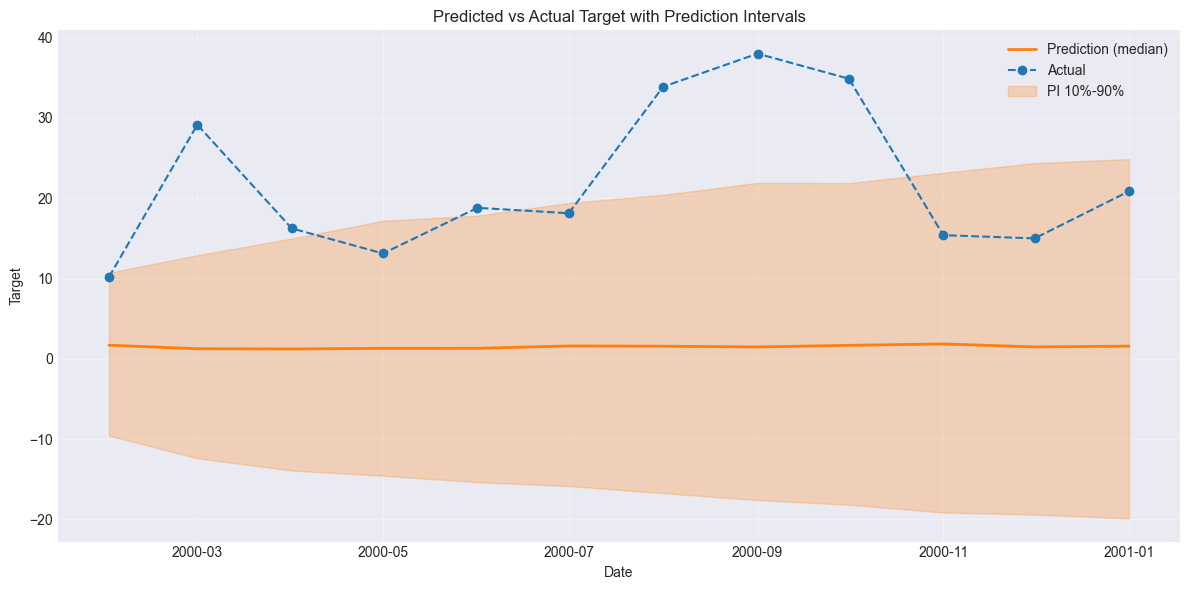

R2: -5.107509030918669
MAE: 20.46853672770874


In [25]:
# Merge predictions with actuals and plot with prediction intervals
merged = pred_df.merge(df_copy_test[['Date', 'Target']], on='Date', how='left')
merged['Date'] = pd.to_datetime(merged['Date'])
merged.set_index('Date', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(merged.index, merged['predictions'], label='Prediction (median)', color='C1', linewidth=2)
plt.plot(merged.index, merged['Target'], label='Actual', color='C0', linestyle='--', marker='o')

# Prediction interval (0.1 - 0.9)
lower_col = '0.1'
upper_col = '0.9'
if lower_col in merged.columns and upper_col in merged.columns:
    plt.fill_between(merged.index, merged[lower_col], merged[upper_col],
                     color='C1', alpha=0.25, label='PI 10%-90%')

plt.title('Predicted vs Actual Target with Prediction Intervals')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print simple metrics on the matched rows
mask = merged['Target'].notna()
if mask.any():
    print('R2:', r2_score(merged.loc[mask, 'Target'], merged.loc[mask, 'predictions']))
    print('MAE:', mean_absolute_error(merged.loc[mask, 'Target'], merged.loc[mask, 'predictions']))
else:
    print('No matching actuals to compute metrics.')


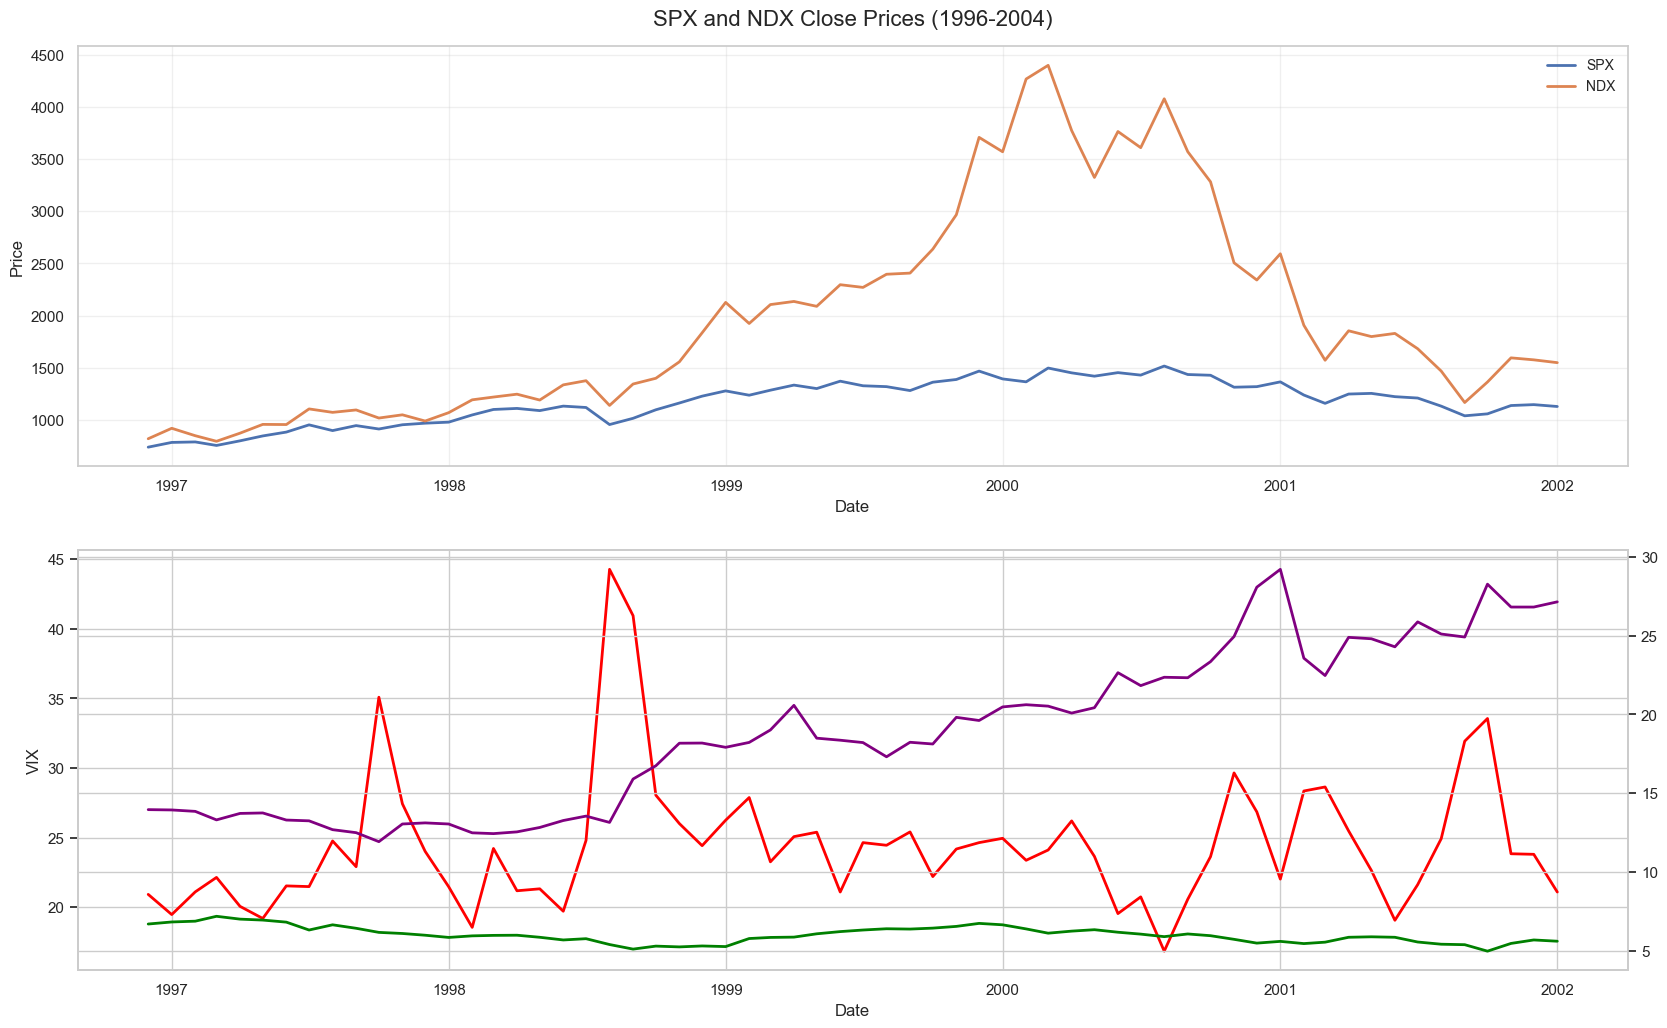

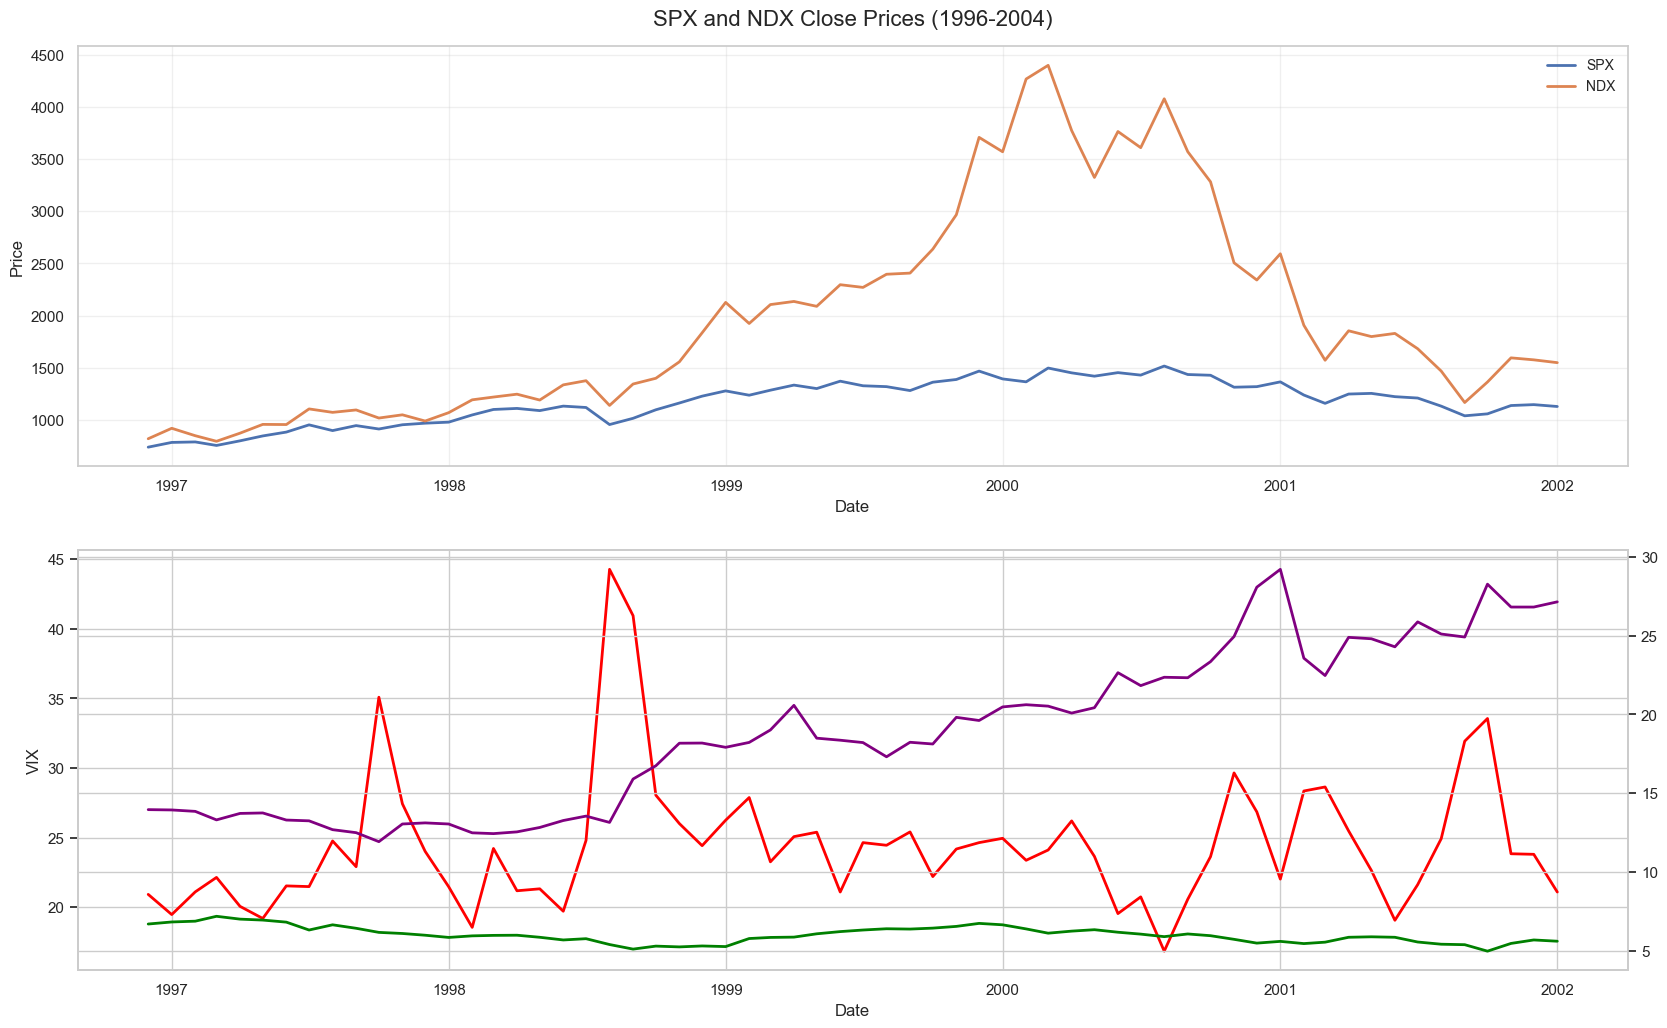

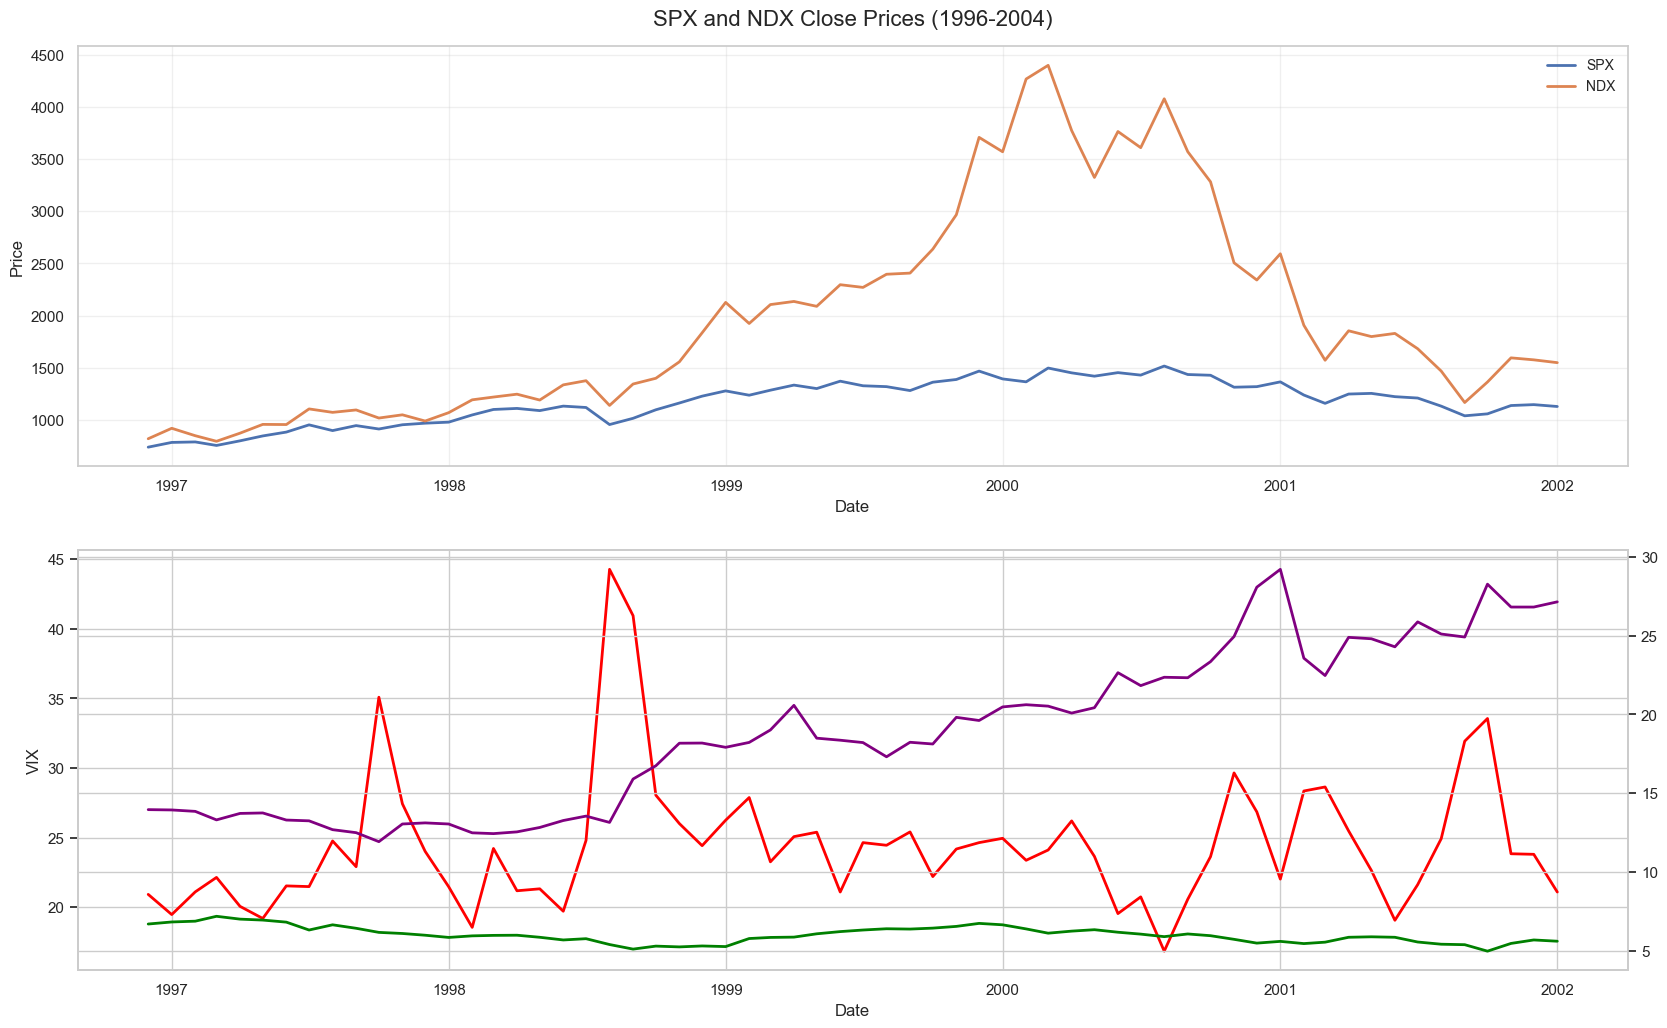

In [44]:


# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Close prices
axes[0].plot(df_1.index, df_1['Close_spx'], label='SPX', linewidth=2)
axes[0].plot(df_1.index, df_1['Close_ndx'], label='NDX', linewidth=2)
axes[0].set_title('SPX and NDX Close Prices (1996-2004)', fontsize=16, pad=15)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: VIX and Yields
ax2 = axes[1]
ax2.plot(df_1.index, df_1['Close_vix'], label='VIX', color='red', linewidth=2)
ax2.set_ylabel('VIX', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)

# Create twin axis for yields
ax2_twin = ax2.twinx()
ax2_twin.plot(df_1.index, df_1['IRLTCT01USM156N'], label='Long Term Yields', 
              color='green', linewidth=2)
ax2_twin.plot(df_1.index, df_1['BAMLH0A3HYCEY'], label='Lower Yields', 
              color='purple', linewidth=2)


# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Close prices
axes[0].plot(df_1.index, df_1['Close_spx'], label='SPX', linewidth=2)
axes[0].plot(df_1.index, df_1['Close_ndx'], label='NDX', linewidth=2)
axes[0].set_title('SPX and NDX Close Prices (1996-2004)', fontsize=16, pad=15)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: VIX and Yields
ax2 = axes[1]
ax2.plot(df_1.index, df_1['Close_vix'], label='VIX', color='red', linewidth=2)
ax2.set_ylabel('VIX', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)

# Create twin axis for yields
ax2_twin = ax2.twinx()
ax2_twin.plot(df_1.index, df_1['IRLTCT01USM156N'], label='Long Term Yields', 
              color='green', linewidth=2)
ax2_twin.plot(df_1.index, df_1['BAMLH0A3HYCEY'], label='Lower Yields', 
              color='purple', linewidth=2)


# Set style with a valid matplotlib style

# Create figure with subplots
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Close prices
axes[0].plot(df_1.index, df_1['Close_spx'], label='SPX', linewidth=2)
axes[0].plot(df_1.index, df_1['Close_ndx'], label='NDX', linewidth=2)
axes[0].set_title('SPX and NDX Close Prices (1996-2004)', fontsize=16, pad=15)
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('Price', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: VIX and Yields
ax2 = axes[1]
ax2.plot(df_1.index, df_1['Close_vix'], label='VIX', color='red', linewidth=2)
ax2.set_ylabel('VIX', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)

# Create twin axis for yields
ax2_twin = ax2.twinx()
ax2_twin.plot(df_1.index, df_1['IRLTCT01USM156N'], label='Long Term Yields', 
              color='green', linewidth=2)
ax2_twin.plot(df_1.index, df_1['BAMLH0A3HYCEY'], label='Lower Yields', 
              color='purple', linewidth=2)

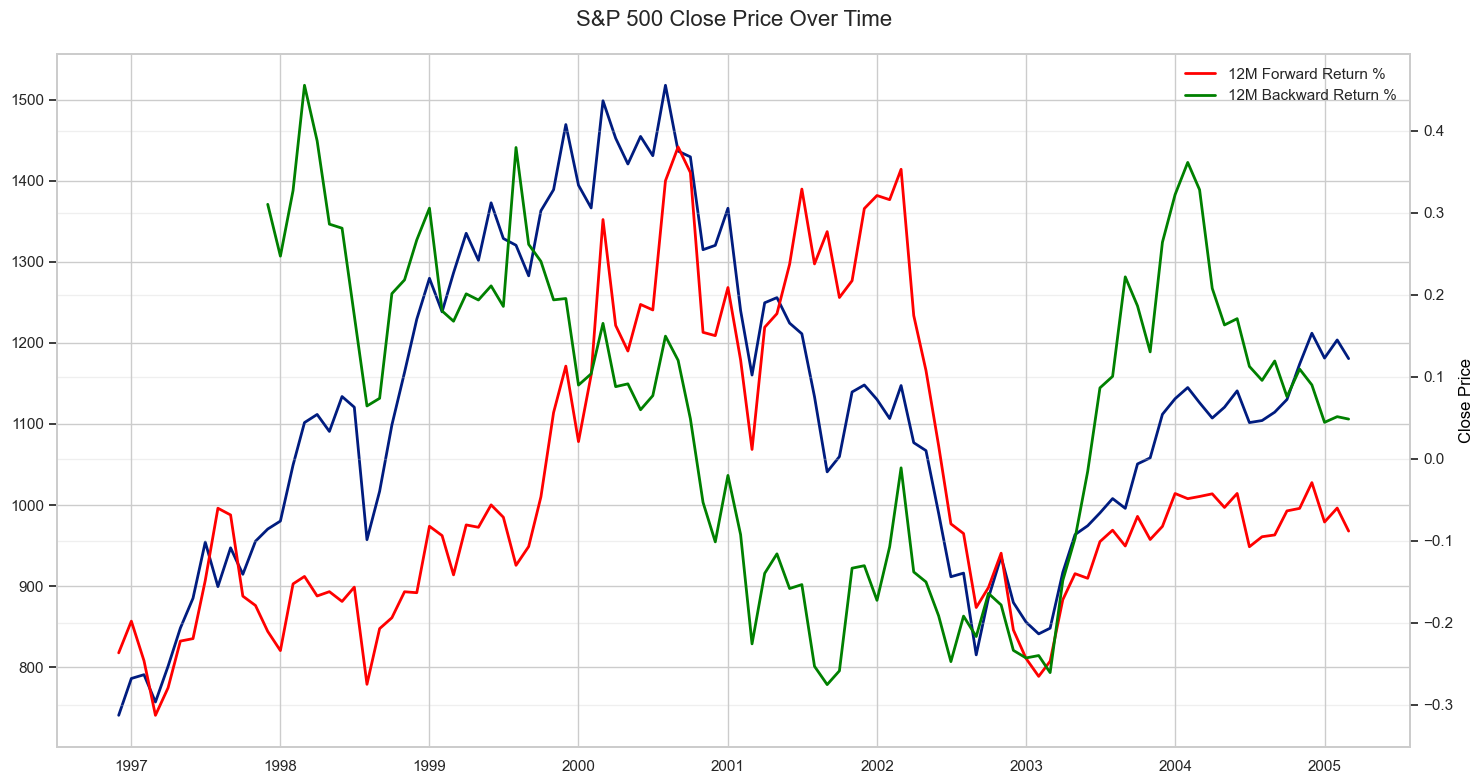

In [45]:


# Set the style
plt.style.use('seaborn-v0_8-dark-palette')

# Create figure with specified size
plt.figure(figsize=(15, 8))

# Plot the data
plt.plot(df['Close_spx'].iloc[:100], linewidth=2)
# Create twin axis for percentage changes
ax_twin = plt.gca().twinx()
ax_twin.plot(df['Close_spx'].pct_change(-12).iloc[:100], linewidth=2, color='red', label='12M Forward Return %')
ax_twin.plot(df['Close_spx'].pct_change(12).iloc[:100], linewidth=2, color='green', label='12M Backward Return %')
ax_twin.set_ylabel('Percentage Change (%)', color='black')
ax_twin.legend(loc='upper right')

# Customize the plot
plt.title('S&P 500 Close Price Over Time', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

In [ ]:


# Define the kernel
kernel = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=1.5)
rbf_kernel = ConstantKernel(10.0) * RBF(length_scale=10.0)
# Initialize and train the GP model
gp = GaussianProcessRegressor(kernel=rbf_kernel, n_restarts_optimizer=10, random_state=42)
gp.fit(X_train, y_train)

# Make predictions with uncertainty estimates
y_pred_mean, y_pred_std = gp.predict(X_test, return_std=True)

# Calculate metrics
r2 = gp.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred_mean)
mae = mean_absolute_error(y_test, y_pred_mean)

print(f'R2: {r2}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

# Plot predictions with uncertainty
plt.figure(figsize=(14, 7))
plt.plot(y_train.index, y_train, 'b-', label='Train Actual')
plt.plot(y_test.index, y_test, 'k-', label='Test Actual')
plt.plot(y_test.index, y_pred_mean, 'r-', label='Predictions')

# Add uncertainty bands (2 standard deviations = 95% confidence interval)
plt.fill_between(y_test.index, 
                 y_pred_mean - 2*y_pred_std,
                 y_pred_mean + 2*y_pred_std,
                 color='r',
                 alpha=0.2,
                 label='95% confidence interval')

plt.title('Gaussian Process Regression with Uncertainty')
plt.xlabel('Date')
plt.ylabel('Target')
plt.legend()
plt.title('Updated Gaussian Process Regression Results')
plt.show()


In [ ]:

# Example usage
test_size = 12  # Number of samples to leave for testing
X_train, X_test, y_train, y_test, scaler,df_copy = prepare_data(df_1, test_size)

# Inspect the splits
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


Train set size: (38, 6) (38,)
Test set size: (12, 6) (12,)


In [10]:

# Example usage
test_size = 12  # Number of samples to leave for testing
X_train, X_test, y_train, y_test, scaler,df_copy = prepare_data(df_2[:-12], test_size)

# Inspect the splits
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


Train set size: (110, 6) (110,)
Test set size: (12, 6) (12,)


In [13]:

# Example usage
test_size = 12  # Number of samples to leave for testing
X_train, X_test, y_train, y_test, scaler,df_copy = prepare_data(df_3[:-12], test_size)

# Inspect the splits
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


Train set size: (277, 6) (277,)
Test set size: (12, 6) (12,)


[I 2025-09-24 11:41:05,619] A new study created in memory with name: no-name-e707ff65-5a78-4b55-9312-508ef5317954


HYPERPARAMETER OPTIMIZATION WITH OPTUNA

Optimizing ElasticNet...


  0%|          | 0/150 [00:00<?, ?it/s]

Starting Time Series Cross-Validation with 5 splits...
Test size: 6 periods, Gap: 0 periods

Fold 1/5
Train period: 1996-12-01 00:00:00 to 2017-06-01 00:00:00
Test period: 2017-07-01 00:00:00 to 2017-12-01 00:00:00
  ElasticNet: R² = -1.034, RMSE = 10.582, MAE = 10.025
--------------------------------------------------
Fold 2/5
Train period: 1996-12-01 00:00:00 to 2017-12-01 00:00:00
Test period: 2018-01-01 00:00:00 to 2018-06-01 00:00:00
  ElasticNet: R² = -7.791, RMSE = 14.150, MAE = 12.881
--------------------------------------------------
Fold 3/5
Train period: 1996-12-01 00:00:00 to 2018-06-01 00:00:00
Test period: 2018-07-01 00:00:00 to 2018-12-01 00:00:00
  ElasticNet: R² = -7.269, RMSE = 20.953, MAE = 18.349
--------------------------------------------------
Fold 4/5
Train period: 1996-12-01 00:00:00 to 2018-12-01 00:00:00
Test period: 2019-01-01 00:00:00 to 2019-06-01 00:00:00
  ElasticNet: R² = -0.605, RMSE = 10.297, MAE = 7.410
-----------------------------------------------

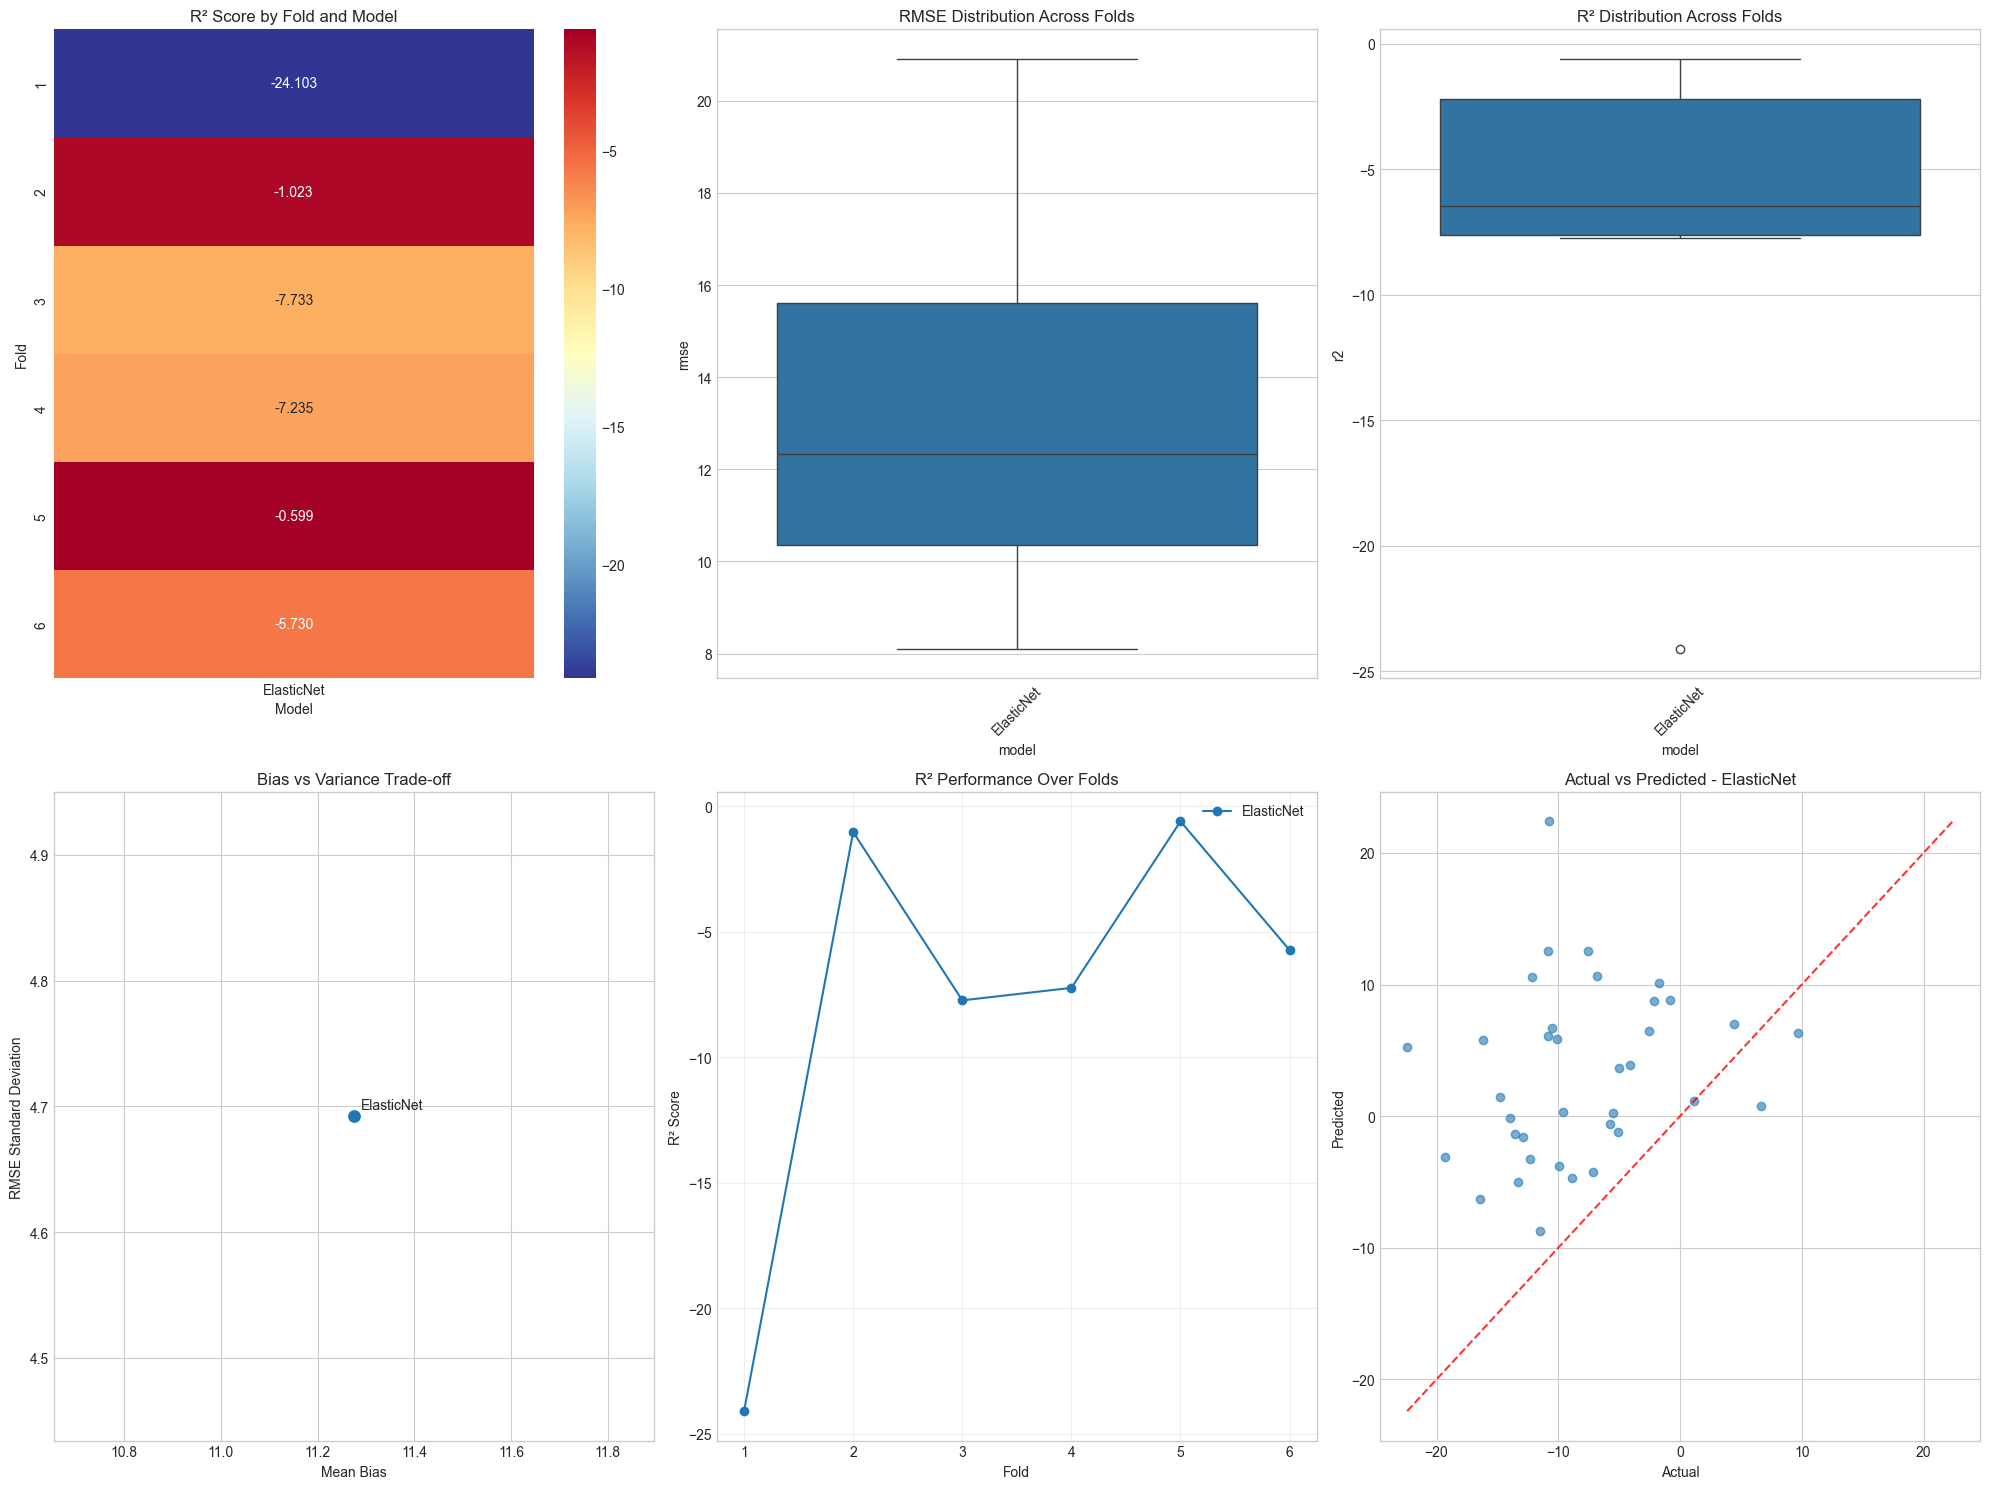

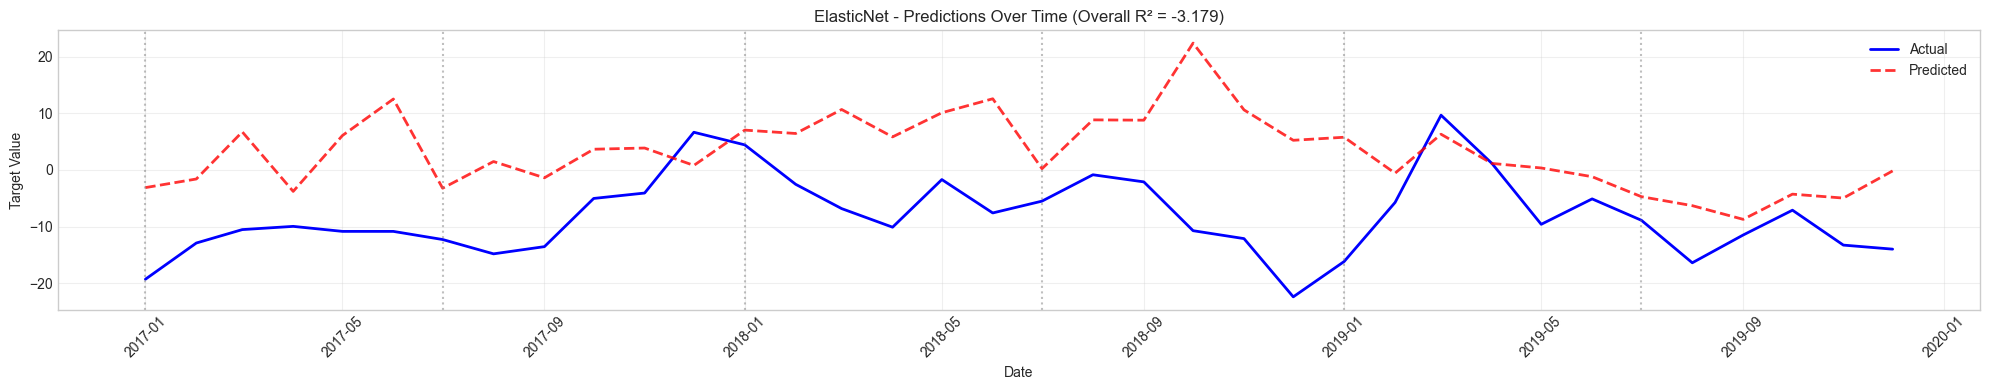


BEST PERFORMING MODEL: ElasticNet
Mean R²: -7.7372 ± 8.5810
Mean RMSE: 13.3448 ± 4.6921
Mean MAE: 11.7867 ± 4.4874

FINAL MODEL PERFORMANCE ON HELD-OUT TEST SET
Test R²: -89.5015
Test RMSE: 51.5795
Test MAE: 47.8539


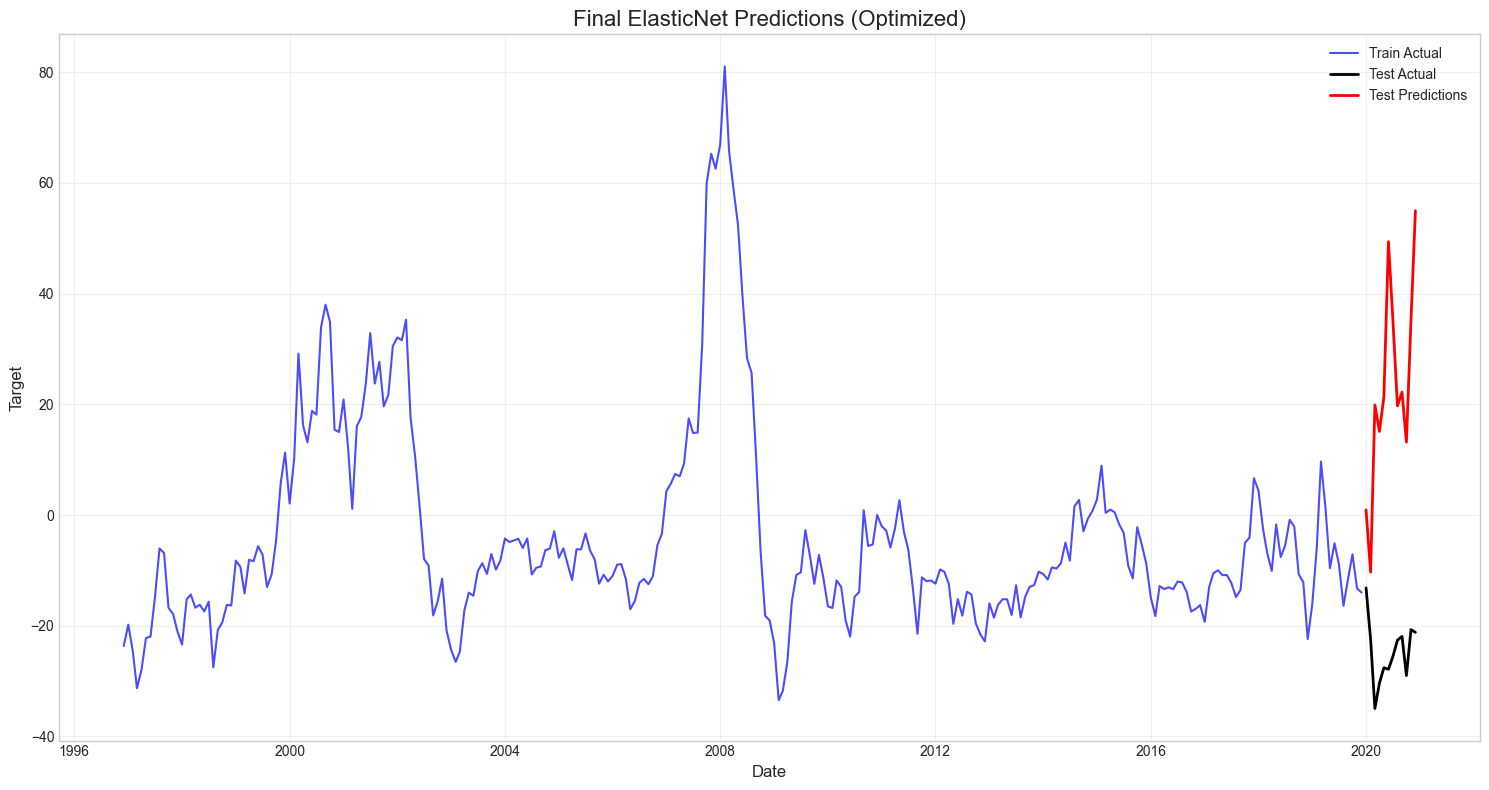


Optimized Model Final Metrics:
R2: -89.5015
MSE: 2660.4494
MAE: 47.8539

HYPERPARAMETER OPTIMIZATION SUMMARY

ElasticNet:
  Best CV R²: -4.4640
  Best Parameters: {'alpha': 0.09890728048582884, 'l1_ratio': 0.9997522065992293}


In [14]:
import optuna
from optuna.samplers import TPESampler
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import ElasticNet

def objective_mlp(trial):
    """Objective function for MLPRegressor hyperparameter optimization"""
    # Suggest hyperparameters
    hidden_layer_sizes = []
    n_layers = trial.suggest_int('n_layers', 1, 5)
    
    for i in range(n_layers):
        layer_size = trial.suggest_int(f'layer_{i}_size', 8, 256)
        hidden_layer_sizes.append(layer_size)
    
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True)
    max_iter = trial.suggest_int('max_iter', 1000, 5000)
    
    # Create model with suggested parameters
    model = MLPRegressor(
        hidden_layer_sizes=tuple(hidden_layer_sizes),
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1
    )
    
    # Perform time series cross-validation
    models_dict = {'MLPRegressor': model}
    results_df, _ = time_series_cv_evaluation(
        X_train, y_train, 
        models_dict, 
        n_splits=6, 
        test_size=6, 
        gap=0
    )
    
    # Return negative mean R2 (optuna minimizes)
    mean_r2 = results_df['r2'].mean()
    return -mean_r2

def objective_rf(trial):
    """Objective function for RandomForest hyperparameter optimization"""
    n_estimators = trial.suggest_int('n_estimators', 5, 100)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )
    
    models_dict = {'RandomForest': model}
    results_df, _ = time_series_cv_evaluation(
        X_train, y_train, 
        models_dict, 
        n_splits=5, 
        test_size=6, 
        gap=0
    )
    
    mean_r2 = results_df['r2'].mean()
    return -mean_r2

def objective_elastic(trial):
    """Objective function for ElasticNet hyperparameter optimization"""
    alpha = trial.suggest_float('alpha', 1e-4, 1e-1, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.0, 1.0)
    
    model = ElasticNet(
        alpha=alpha,
        l1_ratio=l1_ratio,
        random_state=42,
        max_iter=5000
    )
    
    models_dict = {'ElasticNet': model}
    results_df, _ = time_series_cv_evaluation(
        X_train, y_train, 
        models_dict, 
        n_splits=5, 
        test_size=6, 
        gap=0
    )
    
    mean_r2 = results_df['r2'].mean()
    return -mean_r2

def objective_gb(trial):
    """Objective function for GradientBoosting hyperparameter optimization"""
    n_estimators = trial.suggest_int('n_estimators', 5, 100)
    max_depth = trial.suggest_int('max_depth', 3, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    models_dict = {'GradientBoosting': model}
    results_df, _ = time_series_cv_evaluation(
        X_train, y_train, 
        models_dict, 
        n_splits=5, 
        test_size=6, 
        gap=0
    )
    
    mean_r2 = results_df['r2'].mean()
    return -mean_r2

# Define models and their objective functions
# Extend the model_objectives dictionary with ElasticNet
model_objectives = {
    # 'MLPRegressor': objective_mlp,
    # 'RandomForest': objective_rf,
    # 'GradientBoosting': objective_gb,
    'ElasticNet': objective_elastic
}

# Store best models and their parameters
best_models = {}
optimization_results = {}

print("="*80)
print("HYPERPARAMETER OPTIMIZATION WITH OPTUNA")
print("="*80)

# Optimize each model
for model_name, objective_func in model_objectives.items():
    print(f"\nOptimizing {model_name}...")
    
    # Create study
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42)
    )
    
    # Optimize
    study.optimize(objective_func, n_trials=150, show_progress_bar=True)
    
    # Store results
    optimization_results[model_name] = {
        'best_params': study.best_params,
        'best_value': -study.best_value,  # Convert back to positive R2
        'study': study
    }
    
    print(f"Best R2 for {model_name}: {-study.best_value:.4f}")
    print(f"Best parameters: {study.best_params}")

# Create optimized models with best parameters
optimized_models = {}

for model_name, results in optimization_results.items():
    params = results['best_params']
    
    if model_name == 'MLPRegressor':
        # Reconstruct hidden layer sizes
        n_layers = params['n_layers']
        hidden_layer_sizes = []
        for i in range(n_layers):
            hidden_layer_sizes.append(params[f'layer_{i}_size'])
        
        optimized_models[model_name] = MLPRegressor(
            hidden_layer_sizes=tuple(hidden_layer_sizes),
            alpha=params['alpha'],
            learning_rate_init=params['learning_rate_init'],
            max_iter=params['max_iter'],
            random_state=42,
            early_stopping=True,
            validation_fraction=0.1
        )
    
    elif model_name == 'RandomForest':
        optimized_models[model_name] = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            random_state=42
        )
    
    elif model_name == 'GradientBoosting':
        optimized_models[model_name] = GradientBoostingRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42
        )
    elif model_name == 'ElasticNet':
        optimized_models[model_name] = ElasticNet(
            alpha=params['alpha'],
            l1_ratio=params['l1_ratio'],
            random_state=42,
            max_iter=5000
        )

# Run final cross-validation with optimized models
print(f"\n" + "="*80)
print("FINAL CROSS-VALIDATION WITH OPTIMIZED MODELS")
print("="*80)

results_df, fold_predictions = time_series_cv_evaluation(
    X_train, y_train, 
    optimized_models, 
    n_splits=6, 
    test_size=6, 
    gap=0
)

# Create summary table
summary_table = create_results_summary(results_df)
print("\nCROSS-VALIDATION SUMMARY STATISTICS")
print("="*80)
print(summary_table.to_string())

# Plot comprehensive results
fig1 = plot_cv_results(results_df, fold_predictions)
plt.show()

# Plot prediction timelines
fig2 = plot_predictions_timeline(fold_predictions, results_df)
plt.show()

# Get best performing model
best_model_name = summary_table.index[0]
best_model_stats = summary_table.iloc[0]

print(f"\n" + "="*80)
print(f"BEST PERFORMING MODEL: {best_model_name}")
print("="*80)
print(f"Mean R²: {best_model_stats['r2_mean']:.4f} ± {best_model_stats['r2_std']:.4f}")
print(f"Mean RMSE: {best_model_stats['rmse_mean']:.4f} ± {best_model_stats['rmse_std']:.4f}")
print(f"Mean MAE: {best_model_stats['mae_mean']:.4f} ± {best_model_stats['mae_std']:.4f}")

# Train final model on all training data and evaluate on test set
final_model = optimized_models[best_model_name]
final_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_final = final_model.predict(X_test)
test_r2 = r2_score(y_test, y_pred_final)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
test_mae = mean_absolute_error(y_test, y_pred_final)

print(f"\n" + "="*80)
print("FINAL MODEL PERFORMANCE ON HELD-OUT TEST SET")
print("="*80)
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot final predictions
plt.figure(figsize=(15, 8))
plt.plot(y_train.index, y_train, 'b-', label='Train Actual', alpha=0.7)
plt.plot(y_test.index, y_test, 'k-', label='Test Actual', linewidth=2)
plt.plot(y_test.index, y_pred_final, 'r-', label='Test Predictions', linewidth=2)
plt.title(f'Final {best_model_name} Predictions (Optimized)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Target', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Store results for later use
model = final_model
y_pred = pd.Series(y_pred_final, index=y_test.index)
r2 = test_r2
mse = test_rmse**2
mae = test_mae

print(f'\nOptimized Model Final Metrics:')
print(f'R2: {r2:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')

# Print optimization summary
print(f"\n" + "="*80)
print("HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*80)
for model_name, results in optimization_results.items():
    print(f"\n{model_name}:")
    print(f"  Best CV R²: {results['best_value']:.4f}")
    print(f"  Best Parameters: {results['best_params']}")

In [15]:
# Save each optimized model using joblib with the specified naming convention
for i, (model_name, model_instance) in enumerate(optimized_models.items(), 1):
    oracle_name = f"oracle_{3}_{model_instance.__class__.__name__}"
    model_instance.fit(X_train, y_train)  # Ensure the model is trained on the full training set
    print(f"Training {model_name} on full training data...")
    print(f"Saving model as {oracle_name}.joblib")
    # Save to file using joblib
    joblib.dump(model_instance, f"{oracle_name}.joblib")
    # Also keep in globals for immediate use
    print(f"Saved {model_name} as {oracle_name}.joblib")

Training ElasticNet on full training data...
Saving model as oracle_3_ElasticNet.joblib
Saved ElasticNet as oracle_3_ElasticNet.joblib


In [25]:

# Example usage
test_size = 12  # Number of samples to leave for testing
X_train, X_test, y_train, y_test, scaler,df_copy = prepare_data(df_3, test_size)

# Inspect the splits
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)


Train set size: (289, 6) (289,)
Test set size: (12, 6) (12,)


In [ ]:
import joblib
from sklearn.ensemble import VotingRegressor
root_path = r"oracles/"
oracle_number = 3
# Load your pre-trained models (update the naming as needed)
elastic = joblib.load(root_path + f"oracle_{oracle_number}_ElasticNet.joblib")
mlp = joblib.load(root_path + f"oracle_{oracle_number}_MLPRegressor.joblib")
rf = joblib.load(root_path + f"oracle_{oracle_number}_RandomForestRegressor.joblib")
gbr = joblib.load(root_path + f"oracle_{oracle_number}_GradientBoostingRegressor.joblib")

# Wrap the 4 models into an ensemble using VotingRegressor
ensemble = VotingRegressor(
    estimators=[
        ('ElasticNet', elastic),
        ('MLPRegressor', mlp),
        ('RandomForest', rf),
        ('GradientBoosting', gbr)
    ]
)

# Optionally, refit the ensemble on training data if needed.
# For example:
# from your_data_module import X_train, y_train
ensemble.fit(X_train, y_train)

# Save the ensemble model
joblib.dump(ensemble, f"oracle_{oracle_number}_EnsembleRegressor.joblib")
print(f"Ensemble model saved as oracle_{oracle_number}_EnsembleRegressor.joblib")

Ensemble model saved as oracle_3_EnsembleRegressor.joblib


In [48]:

# Set the style
plt.style.use('ggplot')

# Create figure with specified size
plt.figure(figsize=(20, 10))

# Get coefficients and feature names
coefficients = model.coef_
feature_names = X_train.columns

# Create coefficient dictionary and sort by absolute value
coef_dict = dict(zip(feature_names, coefficients))
coef_dict = dict(sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True))

# Create bar plot
bars = plt.bar(range(len(coef_dict)), list(coef_dict.values()))

# Color bars based on positive/negative values
for i, bar in enumerate(bars):
    if bar.get_height() < 0:
        bar.set_color('#FF6B6B')  # Red for negative
    else:
        bar.set_color('#4ECDC4')  # Blue for positive

# Customize the plot
plt.title('Ridge Regression Coefficients (Feature Importance)', fontsize=16, pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(range(len(coef_dict)), list(coef_dict.keys()), rotation=90)

# Add gridlines
plt.grid(True, alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

AttributeError: 'GradientBoostingRegressor' object has no attribute 'coef_'

<Figure size 2000x1000 with 0 Axes>

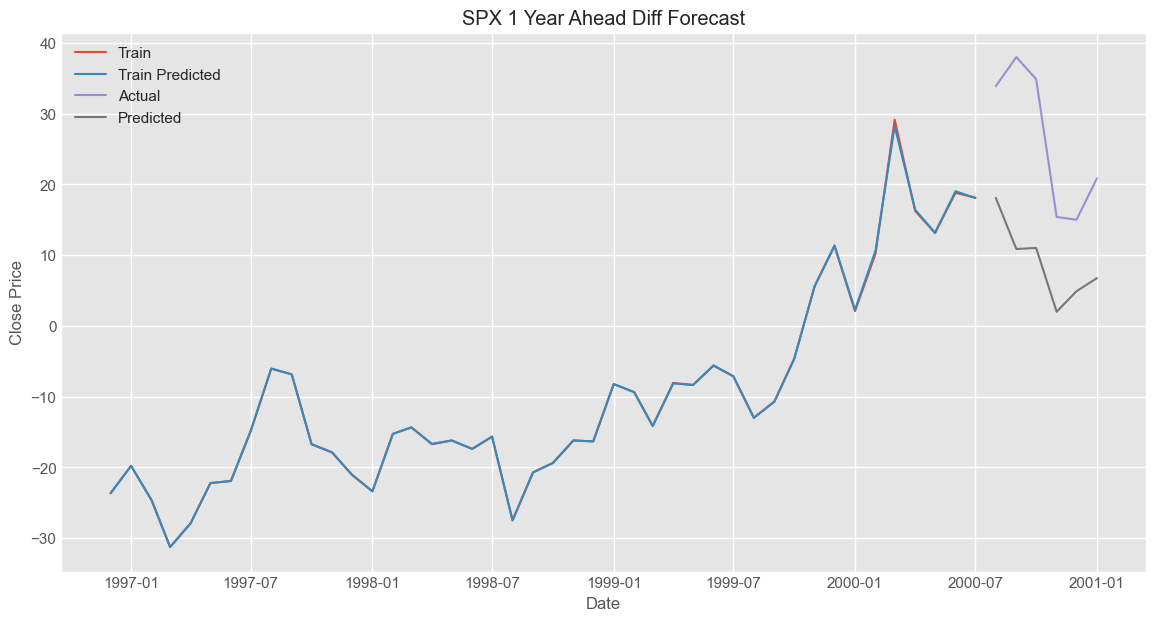

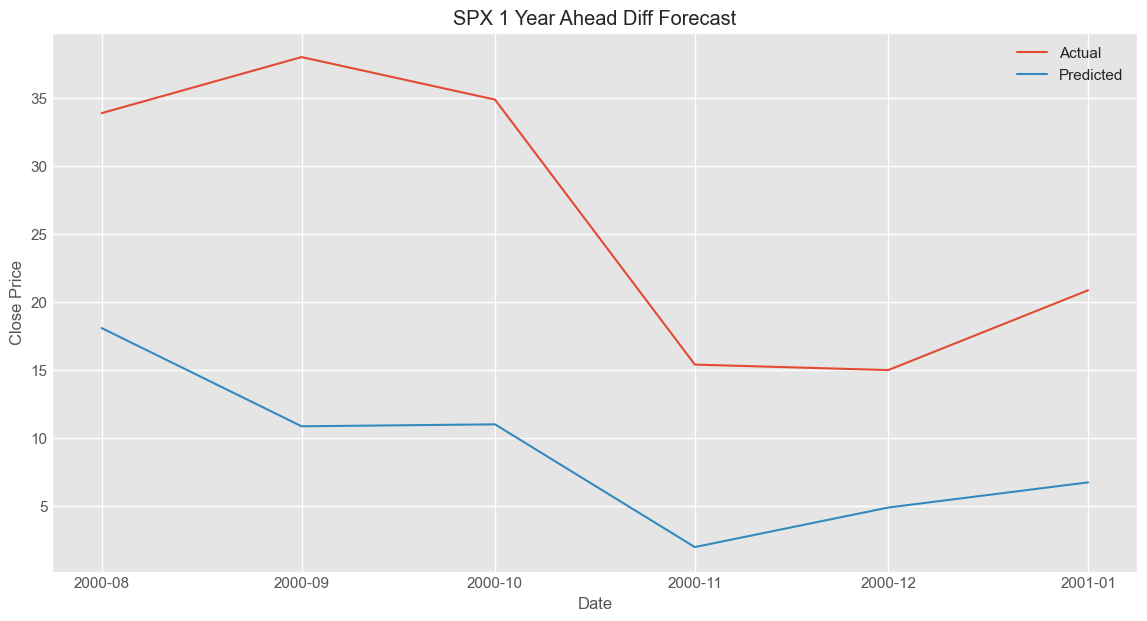

In [49]:

# Show train as well
plt.figure(figsize=(14, 7))
sns.lineplot(x=y_train.index, y=y_train, label='Train')
# add train actual vs train predicted
y_pred_train = pd.Series(model.predict(X_train), index=y_train.index)
sns.lineplot(x=y_train.index, y=y_pred_train, label='Train Predicted')
sns.lineplot(x=y_test.index, y=y_test, label='Actual')
sns.lineplot(x=y_test.index, y=y_pred, label='Predicted')
plt.title('SPX 1 Year Ahead Diff Forecast')
plt.ylabel('Close Price')
plt.legend()

plt.figure(figsize=(14, 7))
sns.lineplot(x=y_test.index, y=y_test, label='Actual')
sns.lineplot(x=y_test.index, y=y_pred, label='Predicted')
plt.title('SPX 1 Year Ahead Diff Forecast')
plt.ylabel('Close Price')
plt.legend()

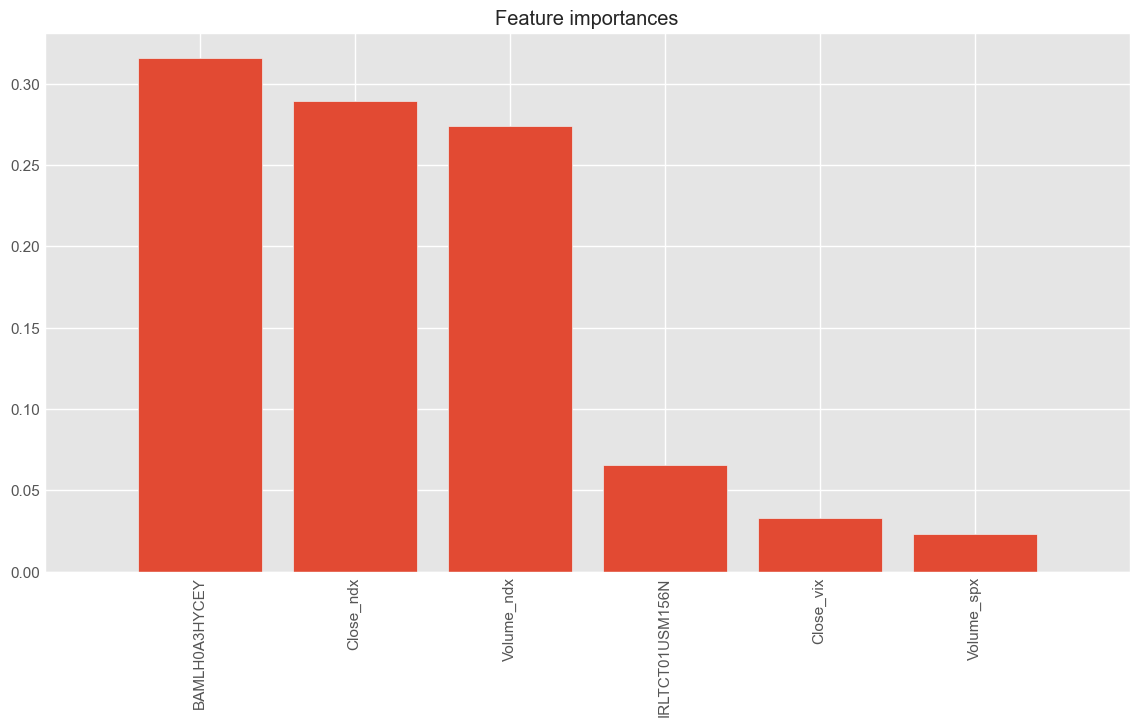

In [50]:
# Plot beautiful feature importance of rf
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(14, 7))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()



In [51]:


# Example Usage
unique_horizons = X_test['forecast_horizon'].unique()
plot_predictions_in_grid(y_test, X_test, model, unique_horizons, n_cols=4)


KeyError: 'forecast_horizon'

In [ ]:
base_cols = ['Close_spx', 'Volume_spx', 'Close_ndx', 'Volume_ndx', 'Close_vix', 'IRLTCT01USM156N', 'BAMLH0A3HYCEY']

In [ ]:
horizons = 12
preds = predict_X_horizons(X_test.iloc[2:3],model,horizons)

In [ ]:
# Plot
plt.figure(figsize=(15, 5))
plt.plot(preds, label='Predicted')
plt.plot(y_test.iloc[0:12].values, label='Actual')
plt.legend()
plt.show()


In [ ]:
preds = []
actuals = []
for unique_y in y_test.unique():
    range_vals = y_test[y_test.between(unique_y-0.0001,unique_y+0.0001)].index
    actual = y_test[y_test.index.isin(range_vals)].mean()
    preds_1 = pd.Series(model.predict(X_test[X_test.index.isin(range_vals)]))
    q95 = preds_1.quantile(0.999)
    q5 = preds_1.quantile(0.001)
    mean_pred = preds_1.median()
    print(f"q95: {q95},q5: {q5}mean: {mean_pred},actual: {actual}")
    preds.append((q95,q5,mean_pred))
    actuals.append(actual)


# Plot with confidence intervals
plt.figure(figsize=(15, 5))
plt.plot(actuals, label='Actual', color='blue')
plt.plot([pred[2] for pred in preds], label='Predicted', color='orange')
plt.fill_between(range(len(preds)), [pred[0] for pred in preds], [pred[1] for pred in preds], color='orange', alpha=0.3)
plt.legend()
plt.show()





In [ ]:
# Feature Importance
importances = model.coef_
features = X_train.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(20, 8))
sns.barplot(x=features[indices], y=importances[indices])
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Plot Coefficients
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=X_train.columns, y=ridge.coef_)
plt.title('Ridge Regression Coefficients')
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)

# Add value labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()


In [ ]:
# get 2007-01-01
X_train = X_train.loc['2007-01-01':]

In [ ]:
df.loc['2007-01-01':]

In [ ]:
X_train

In [ ]:
# Extract B0
b0 = ridge.intercept_

In [ ]:
b0

## Step further Augmentation by Task and Horizon ( can also add transformation )

In [ ]:


# Example Usage
horizons = [1, 2, 3,4,5,6]
tasks = ["regression", "trend", "percent_change"]
augmented_df = augment_by_task(df, "Close_spx", horizons, tasks)

print(augmented_df.head())
